<a href="https://colab.research.google.com/github/pachterlab/BBB/blob/master/notebooks/crohn_lesion_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bioinformatics for Benched Biologists
This R notebook demonstrates the analysis of a ~3000 cell dataset from a Crohn's disease lesion obtained from surgical resection. It was designed for a 2 hour Zoom workshop, but runs on Google Colab in about 26 minutes.

The dataset used here was taken from this paper:

Jerome C. Martin, et al.
**Single-Cell Analysis of Crohn’s Disease Lesions Identifies a Pathogenic Cellular Module Associated with Resistance to Anti-TNF Therapy**,
Cell,
Volume 178, Issue 6,
2019,
Pages 1493-1508.e20,
ISSN 0092-8674,
https://doi.org/10.1016/j.cell.2019.08.008.

Lamina propria was isolated from the lesion and adjacent healthy ileal tissue from 11 patients. Then scRNA-seq (10xv1 and v2) was performed on the 22 samples, from which Martin et al. discovered a distinct cellular response only present in a subset of patients. In the original analysis, 82417 cells passed quality controls. This notebook uses one of these 22 samples, with about 3000 cells, to demonstrate basic scRNA-seq data analysis. The GEO accession of the sample used here is [GSM3972013](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3972013). The data for this sample was generated with 10xv2.

These are citations of the methods used in analyses in this notebook:

* `kallisto | bustools`: Melsted, Páll, A. Sina Booeshaghi, Fan Gao, Eduardo da Veiga Beltrame, Lambda Lu, Kristján Eldjárn Hjorleifsson, Jase Gehring, and Lior Pachter. "Modular and efficient pre-processing of single-cell RNA-seq." BioRxiv (2019): 673285.
* Knee plot: Macosko, Evan Z. et al. "Highly Parallel Genome-wide Expression Profiling of Individual Cells Using Nanoliter Droplets." Cell, Volume 161, Issue 5, 1202 - 1214
* Seurat: Stuart, Tim et al. "Comprehensive Integration of Single-Cell Data." Cell, Volume 177, Issue 7, 1888 - 1902.e21
* `SCTransform`: Hafemeister, C., Satija, R. Normalization and variance stabilization of single-cell RNA-seq data using regularized negative binomial regression. Genome Biol 20, 296 (2019).
* Leiden clustering: Traag, Vincent A., Ludo Waltman, and Nees Jan van Eck. "From Louvain to Leiden: guaranteeing well-connected communities." Scientific reports 9, no. 1 (2019): 1-12.
* tSNE: Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9, no. Nov (2008): 2579-2605.
* UMAP: Leland McInnes, John Healy, and James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction." arXiv (2018): 1802.03426.
* Logistic regression differential expression test: Ntranos, V., Yi, L., Melsted, P. et al. A discriminative learning approach to differential expression analysis for single-cell RNA-seq. Nat Methods 16, 163–166 (2019).
* Fisher's exact test: Fisher, R.A. "Statistical Methods for Research Workers." (1934)

## Setup

### Install packages
The R package Seurat, which is commonly used for scRNA-seq data analysis, will be used in this notebook. Since Seurat is a huge package with many dependencies, many of which are not used here, we provide a slimmed down version of Seurat called [SeuratBasics](https://github.com/lambdamoses/SeuratBasics) to reduce package installation time. The `leidenbase` package from Cole Trapnell lab, which is not yet on CRAN, will be used for Leiden clustering. With the `Ncpus` argument of `install.packages`, we can use multiple CPUs to install packages concurrently. With 2 cores, the full Seurat would take between 20 and 30 minutes to install on Google Colab. In contrast, installing both `leidenbase` and `SeuratBasics` typically takes between 10 and 11 minutes. 

This notebook makes heavy use of Tidyverse for data wrangling and plotting. To learn more about Tidyverse, we strongly recommend [R for Data Science](https://r4ds.had.co.nz/) by Garrett Grolemund and Hadley Wickham. Tidyverse is preinstalled on Google Colab.

For a more comprehensive overview of scRNA-seq data analysis, see the free ebook [Orchestrating Single-Cell Analysis with Bioconductor](https://osca.bioconductor.org/).

In [0]:
start_time <- Sys.time()
system.time({
  devtools::install_github("cole-trapnell-lab/leidenbase", upgrade = "never")
  devtools::install_github("lambdamoses/SeuratBasics", upgrade = "never", Ncpus = 2)
})


Installing 1 packages: igraph

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpJkPc3N/remotes7c5079e934/cole-trapnell-lab-leidenbase-c22a7d0/DESCRIPTION’
─  preparing ‘leidenbase’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories (519ms)
─  building ‘leidenbase_0.1.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Installing 25 packages: cowplot, future, future.apply, ggrepel, ggridges, irlba, lmtest, patchwork, pbapply, png, RANN, Rtsne, sctransform, uwot, RcppEigen, RcppProgress, globals, listenv, sitmo, zoo, gridExtra, FNN, RSpectra, RcppAnnoy, dqrng

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpJkPc3N/remotes7c28a65e34/lambdamoses-SeuratBasics-f5c0a6e/DESCRIPTION’
─  preparing ‘SeuratBasics’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘SeuratBasics_0.0.99.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



   user  system elapsed 
707.433  65.041 617.798 

Install the `kb-python` wrapper of `kallisto` and `bustools` to get from fastq files to the gene count matrix.

In [0]:
system("pip3 install kb-python")

Download a prebuilt `kallisto` index for _Homo sapiens_ and the transcript to gene file. 

In [0]:
system("kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta")

In [0]:
library(tidyverse)
library(SeuratBasics)
library(Matrix)
library(ggrepel)
library(patchwork)
library(tidyselect)
theme_set(theme_bw())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




### Download the data
Fortunately, for this study, the original fastq files can be directly downloaded from SRA, though this isn't normally the case. Normally, [`fasterq-dump` from the SRA Toolkit](https://github.com/ncbi/sra-tools/wiki/HowTo:-fasterq-dump). is used to download fastq files from SRA, though the European Nucleotide Archive (ENA) provides fastq files that can be downloaded directly. Here we construct the URLs to the fastq files.

In [0]:
prefixes <- paste0("https://sra-pub-src-2.s3.amazonaws.com/SRR982774", 3:6, "/")
mids <- paste0("128_S2_L00", 1:4, "_R")
suff1 <- paste0(mids, 1, "_001.fastq.gz.1")
suff2 <- paste0(mids, 2, "_001.fastq.gz.1")
urls1 <- map2_chr(prefixes, suff1, ~ paste0(.x, .y))
urls2 <- map2_chr(prefixes, suff2, ~ paste0(.x, .y))
(urls <- as.vector(rbind(urls1, urls2)))

[1] "https://sra-pub-src-2.s3.amazonaws.com/SRR9827743/128_S2_L001_R1_001.fastq.gz.1"
[2] "https://sra-pub-src-2.s3.amazonaws.com/SRR9827743/128_S2_L001_R2_001.fastq.gz.1"
[3] "https://sra-pub-src-2.s3.amazonaws.com/SRR9827744/128_S2_L002_R1_001.fastq.gz.1"
[4] "https://sra-pub-src-2.s3.amazonaws.com/SRR9827744/128_S2_L002_R2_001.fastq.gz.1"
[5] "https://sra-pub-src-2.s3.amazonaws.com/SRR9827745/128_S2_L003_R1_001.fastq.gz.1"
[6] "https://sra-pub-src-2.s3.amazonaws.com/SRR9827745/128_S2_L003_R2_001.fastq.gz.1"
[7] "https://sra-pub-src-2.s3.amazonaws.com/SRR9827746/128_S2_L004_R1_001.fastq.gz.1"
[8] "https://sra-pub-src-2.s3.amazonaws.com/SRR9827746/128_S2_L004_R2_001.fastq.gz.1"

Construct the file names for download.

In [0]:
(file_names <- as.vector(rbind(suff1, suff2)))

[1] "128_S2_L001_R1_001.fastq.gz.1" "128_S2_L001_R2_001.fastq.gz.1"
[3] "128_S2_L002_R1_001.fastq.gz.1" "128_S2_L002_R2_001.fastq.gz.1"
[5] "128_S2_L003_R1_001.fastq.gz.1" "128_S2_L003_R2_001.fastq.gz.1"
[7] "128_S2_L004_R1_001.fastq.gz.1" "128_S2_L004_R2_001.fastq.gz.1"

Actually the data can be streamed into `kallisto` and `bustools` without downloading the whole thing, but for reference this is the code to download the dataset:

In [0]:
#for (i in seq_along(urls)) {
#  if (!file.exists(file_names[i])) download.file(urls[i], file_names[i])
#}
#list.files(".", pattern = "*.fastq.gz")

### Generate the gene count matrix
Here we will stream the fastq files to make the gene count matrix. It's actually faster than first downloading the whole thing.

In [0]:
(command <- paste("kb count -i index.idx -g t2g.txt -x 10xv2 -o output -t2",
                  paste(urls, collapse = " ")))

[1] "kb count -i index.idx -g t2g.txt -x 10xv2 -o output -t2 https://sra-pub-src-2.s3.amazonaws.com/SRR9827743/128_S2_L001_R1_001.fastq.gz.1 https://sra-pub-src-2.s3.amazonaws.com/SRR9827743/128_S2_L001_R2_001.fastq.gz.1 https://sra-pub-src-2.s3.amazonaws.com/SRR9827744/128_S2_L002_R1_001.fastq.gz.1 https://sra-pub-src-2.s3.amazonaws.com/SRR9827744/128_S2_L002_R2_001.fastq.gz.1 https://sra-pub-src-2.s3.amazonaws.com/SRR9827745/128_S2_L003_R1_001.fastq.gz.1 https://sra-pub-src-2.s3.amazonaws.com/SRR9827745/128_S2_L003_R2_001.fastq.gz.1 https://sra-pub-src-2.s3.amazonaws.com/SRR9827746/128_S2_L004_R1_001.fastq.gz.1 https://sra-pub-src-2.s3.amazonaws.com/SRR9827746/128_S2_L004_R2_001.fastq.gz.1"

In [0]:
system.time(system(command))

   user  system elapsed 
616.260  29.214 426.111 

It only took about 8 minutes (the `elapsed` field in seconds). The `user` field is larger becuase 2 cores were used. How did it go?

In [0]:
system("cat output/run_info.json", intern = TRUE)

[1] "{"                                                                                                                                                                                                                                                                                                                                                                                                                     
 [2] "\t\"n_targets\": 0,"                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "\t\"n_bootstraps\": 0,"                                                                                                                                                                                                                                                                                                                                                                                                
 [4] "\t\"n_processed\": 57360017,"                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "\t\"n_pseudoaligned\": 34164485,"                                                                                                                                                                                                                                                                                                                                                                                      
 [6] "\t\"n_unique\": 11952319,"                                                                                                                                                                                                                                                                                                                                                                                             
 [7] "\t\"p_pseudoaligned\": 59.6,"                                                                                                                                                                                                                                                                                                                                                                                          
 [8] "\t\"p_unique\": 20.8,"                                                                                                                                                                                                                                                                                                                                                                                                 
 [9] "\t\"kallisto_version\": \"0.46.1\","                                                                                                                                                                                                                                                                                                                                                                                   
[10] "\t\"index_version\": 0,"                                                                                                                                                                                                                                                     

## Quality controls

In [0]:
# Slightly modified from BUSpaRse, just to avoid installing a few dependencies not used here
read_count_output <- function(dir, name) {
  dir <- normalizePath(dir, mustWork = TRUE)
  m <- readMM(paste0(dir, "/", name, ".mtx"))
  m <- Matrix::t(m)
  m <- as(m, "dgCMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  con_genes <- file(paste0(dir, "/", name, ge))
  con_bcs <- file(paste0(dir, "/", name, ".barcodes.txt"))
  genes <- readLines(con_genes)
  barcodes <- readLines(con_bcs)
  colnames(m) <- barcodes
  rownames(m) <- genes
  close(con_genes)
  close(con_bcs)
  return(m)
}

In [0]:
mat <- read_count_output("./output/counts_unfiltered", name = "cells_x_genes")

In [0]:
tot_cells <- colSums(mat)
summary(tot_cells)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     1.00     1.00    73.26     5.00 53122.00 

In [0]:
tot_genes <- rowSums(mat)
summary(tot_genes)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      0.0       0.0       1.0     214.7      24.0 2867754.0 

In [0]:
mat <- mat[tot_genes > 0, tot_cells > 0]

In [0]:
dim(mat)

[1]  31193 156849

The vase majority of barcodes have very few or no UMI counts. Those are empty droplets. The reason why so many empty droplets is to reduce the probability of loading two separate cells into the same droplet.

### Remove empty droplets
The inflection point of the knee plot is commonly used to determine how many "real" cells are there and the minimum total UMI counts for a barcode to count as a "real" cell. The knee plot plots the total UMI count for each barcode on the y axis and the rank of the total count on the x axis, with log-log scale, and usually an inflection point can be clearly seen on the plot. 

Here we flipped the x and y axis, since this can be better generalized for multi-modal data, such as those with both RNA and protein data and those with spliced and unspliced counts. 

Seurat actually has a function to find the inflection point, but it doesn't work very well, so this is implemented from scratch here and will be added to BUSpaRse for the Bioconductor 3.11 release.

Note that the `#'` comments are converted into documentation pages by Roxygen2 in R packages.

In [0]:
#' Get data frame for plotting knee plot
#'
#' @param mat Gene count matrix, a dgCMatrix.
#' @return A tibble with two columns: \code{total} for total UMI counts for 
#' each barcode, and \code{rank} for rank of the total counts, with number 1
#' for the barcode with the most counts.
get_knee_df <- function(mat) {
  tibble(total = colSums(mat),
         rank = row_number(desc(total))) %>%
    distinct() %>%
    filter(total > 0) %>% 
    arrange(rank)
}

In [0]:
#' Compute inflection point of knee plot
#'
#' Code adapted from \code{DropetUtils}.
#'
#' @param df The data frame from \code{get_knee_df}.
#' @param lower Minimum total UMI counts for barcode for it to be considered
#' when calculating the inflection point; this helps to avoid the noisy part of
#' the curve for barcodes with very few counts.
#' @return A \code{numeric(1)} for the total UMI count at the inflection point.
get_inflection <- function(df, lower = 100) {
  df_fit <- df %>% 
    filter(total > lower) %>% 
    transmute(log_total = log10(total),
              log_rank = log10(rank))
  d1n <- diff(df_fit$log_total)/diff(df_fit$log_rank)
  right.edge <- which.min(d1n)
  10^(df_fit$log_total[right.edge])
}

In [0]:
#' Plot the transposed knee plot and inflection point
#' 
#' @param df The data frame from \code{get_knee_df}.
#' @param inflection Output of get_inflection
#' @return A \code{ggplot2} object.
knee_plot <- function(df, inflection) {
  annot <- tibble(inflection = inflection,
                  rank_cutoff = max(df$rank[df$total > inflection]))
  ggplot(df, aes(total, rank)) +
    geom_path() +
    geom_vline(aes(xintercept = inflection), data = annot, linetype = 2, color = "gray40") +
    geom_hline(aes(yintercept = rank_cutoff), data = annot, linetype = 2, color = "gray40") +
    geom_text_repel(aes(inflection, rank_cutoff, 
                        label = paste(rank_cutoff, "'cells'")), size = 5,
                    data = annot) +
    scale_x_log10() +
    scale_y_log10() +
    labs(y = "Rank", x = "Total UMIs") +
    annotation_logticks() +
    theme(axis.text = element_text(size = 12),
          axis.title = element_text(size = 14),
          legend.title = element_text(size = 14))
}

`options(repr.plot.width=9, repr.plot.height=6)` is used to adjust figure size; in R Markdown, use `fig.width = 9, fig.height = 6` in the chunk options instead.

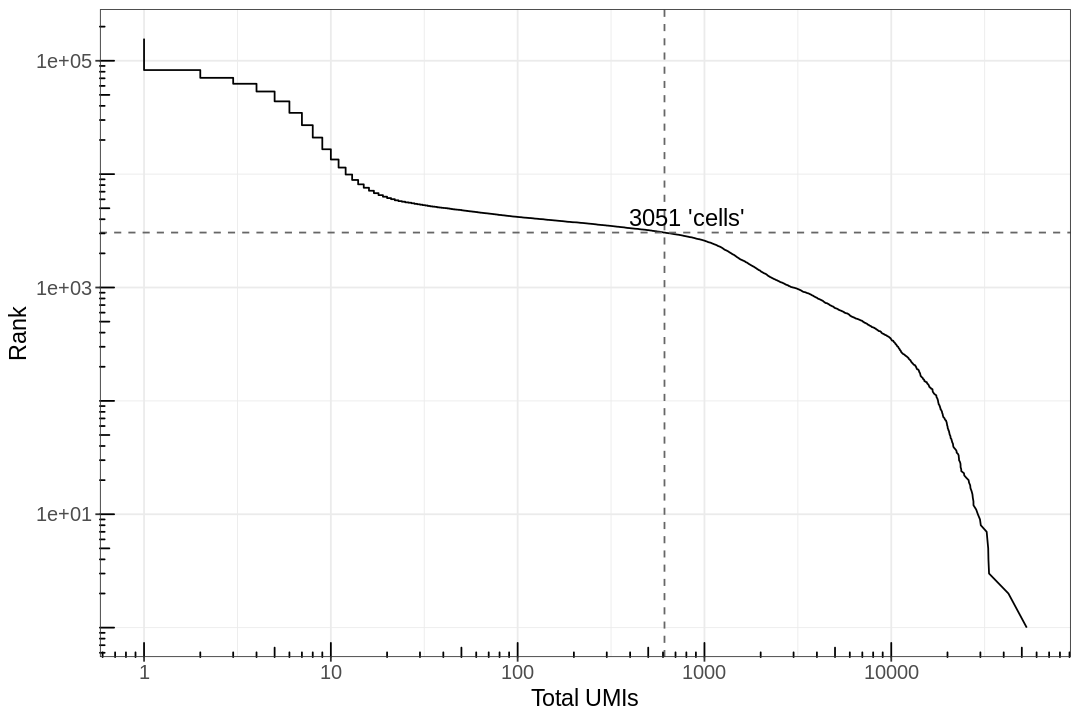

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
df <- get_knee_df(mat)
infl <- get_inflection(df, lower = 400)
knee_plot(df, infl)

In [0]:
mat_filtered <- mat[, colSums(mat) > infl]
mat_filtered <- mat_filtered[rowSums(mat_filtered) > 0, ]
dim(mat_filtered)

[1] 30524  3051

What proportion of UMIs are from the "real" cells?

In [0]:
sum(mat_filtered)/sum(mat)

[1] 0.9272206

That's good. Now the row names of the matrix are Ensembl gene IDs, which are not very human readable, so we'll convert them to gene symbols. Note that one gene symbol can correspond to multiple Ensembl IDs; often these different symbols denote the same gene on different haplotypes, though there seem to be other reasons why a gene symbol can have multiple Ensembl IDs. The same gene can also have multiple gene symbols. These are the reasons why Ensembl IDs have been used so far.

In [0]:
gns <- read_tsv("t2g.txt", col_names = c("transcript", "gene", "symbol")) %>% 
  select(-transcript) %>% 
  distinct()
rownames(mat_filtered) <- gns$symbol[match(rownames(mat_filtered), gns$gene)]

Parsed with column specification:
cols(
  transcript = col_character(),
  gene = col_character(),
  symbol = col_character()
)



### Remove low quality cells

In [0]:
#' Plot scatter plot side by side with density
#' 
#' A way to mitigate overplotting, which makes it difficult to see the density
#' of points on a plot even with translucent points.
#' 
#' @parem seu Seurat object.
#' @param features Character vector of length 2 for the columns in the meta.data
#' slot to be plotted.
#' @param size Point size for scatter plot.
#' @param alpha Point opacity for scatter plot.
#' @param bins Numbers of bins for density plot.
#' @param log Whether to plot x and/or y axis on log scale.
#' @param xlab Label of x axis for both plots.
#' @param ylab Label of y axis for both plots.
#' @return Two ggplots patched together by \code{patchwork}.
plot_scatter_density <- function(seu, features, size = 0.5, alpha = 0.1,
                                 bins = 100, log = c("xy", "x", "y", "none"),
                                 xlab = NULL, ylab = NULL) {
  log <- match.arg(log)
  features <- intersect(features, names(seu@meta.data))
  if (length(features) < 2) {
    stop("Need 2 features to plot.")
  }
  if (length(features) > 2) {
    features <- features[1:2]
    warning("The first two elements of features are used.")
  }
  p <- ggplot(seu@meta.data, aes_string(features[1], features[2])) +
    theme(axis.text = element_text(size = 12),
          axis.title = element_text(size = 14),
          legend.title = element_text(size = 14))
  if (!is.null(xlab)) p <- p + xlab(xlab)
  if (!is.null(ylab)) p <- p + ylab(ylab)
  p <- switch(
    log,
    xy = p + scale_x_log10() + scale_y_log10() + annotation_logticks(),
    x = p + scale_x_log10() + annotation_logticks(sides = "b"),
    y = p + scale_y_log10() + annotation_logticks(sides = "l"),
    none = p
  )
  p1 <- p +
  geom_point(size = size, alpha = alpha)
  p2 <- p +
    geom_bin2d(bins = bins) +
    scale_fill_distiller(palette = "Blues", direction = 1)
  p1 + p2
}

In [0]:
seu <- CreateSeuratObject(mat_filtered)

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


#### Library saturation
Can we detect more genes by increasing sequencing depth?

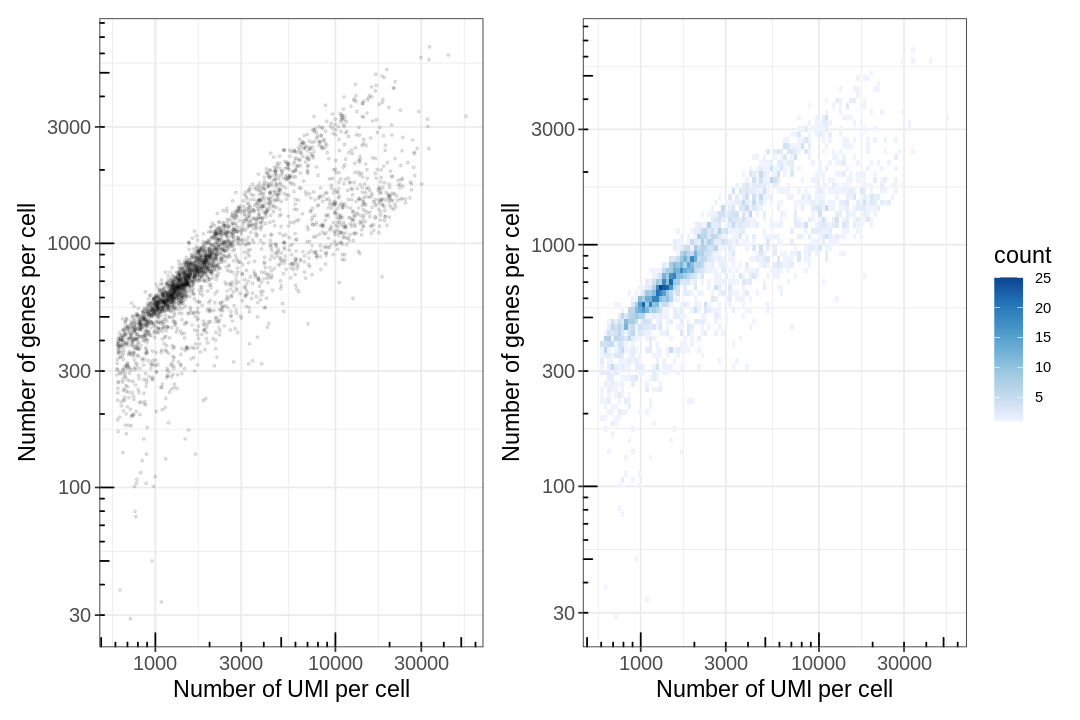

In [0]:
ncount_lab <- "Number of UMI per cell"
plot_scatter_density(seu, c("nCount_RNA", "nFeature_RNA"),
                     xlab = ncount_lab, 
                     ylab = "Number of genes per cell")

There are a few cells with very high counts, which might be doublets. This is not a formal test for whether a droplet has a doublet. There are packages like [`DoubletFinder`](https://github.com/chris-mcginnis-ucsf/DoubletFinder) for this.

In [0]:
seu <- seu[, seu$nCount_RNA < 4e4]

#### Percentage of mitochondrial counts
Cells with high percentage of mitochondrial counts are usually deemed low quality and removed because when a cell bursts during sample preparation, transcripts in the cytoplasm are more easily lost than mitochondrially encoded transcripts, which are protected by the double membrane of mitochondria.

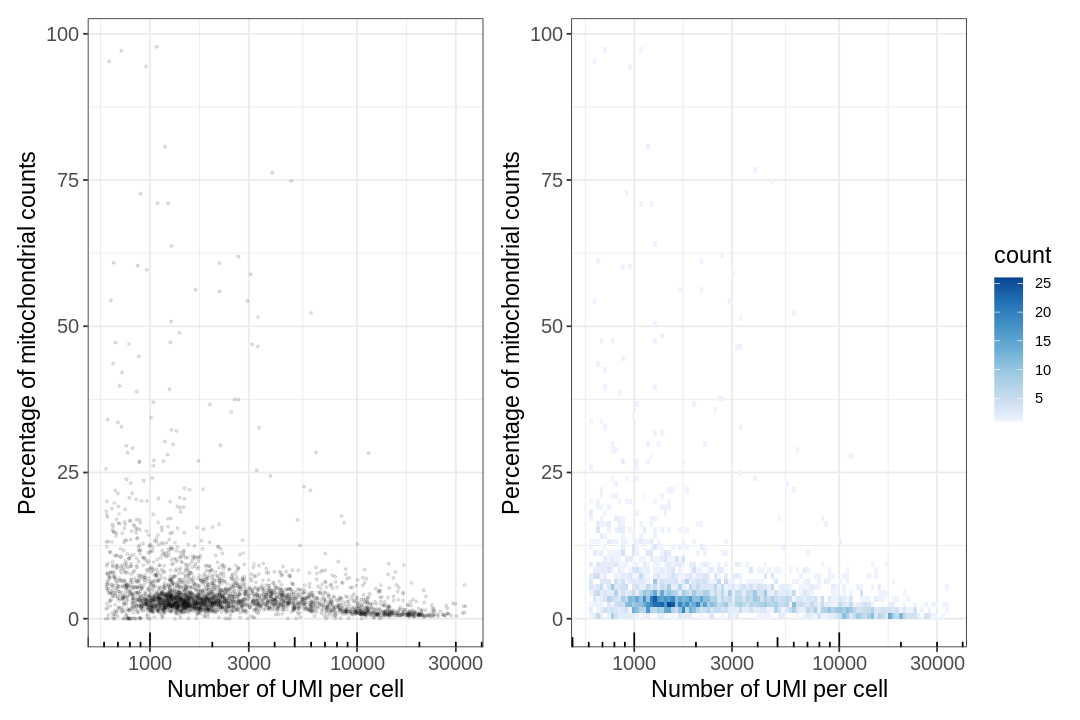

In [0]:
seu$pct_mt <- PercentageFeatureSet(seu, pattern = "^MT-")
plot_scatter_density(seu, features = c("nCount_RNA", "pct_mt"),
                     log = "x", xlab = ncount_lab,
                     ylab = "Percentage of mitochondrial counts")

Sort of arbitrary; 20% seems like a good cutoff based on this plot.

In [0]:
seu <- seu[, seu$pct_mt < 20]

#### Other low quality cells
In this paper, the authors also removed epithelial cells, i.e. cells with >1% UMIs from epithelial marker genes, because collagenase digestion severely alters epithelial cell integrity. Red blood cells, or cells with more than 10% UMIs from hemoglobin genes, were also removed.

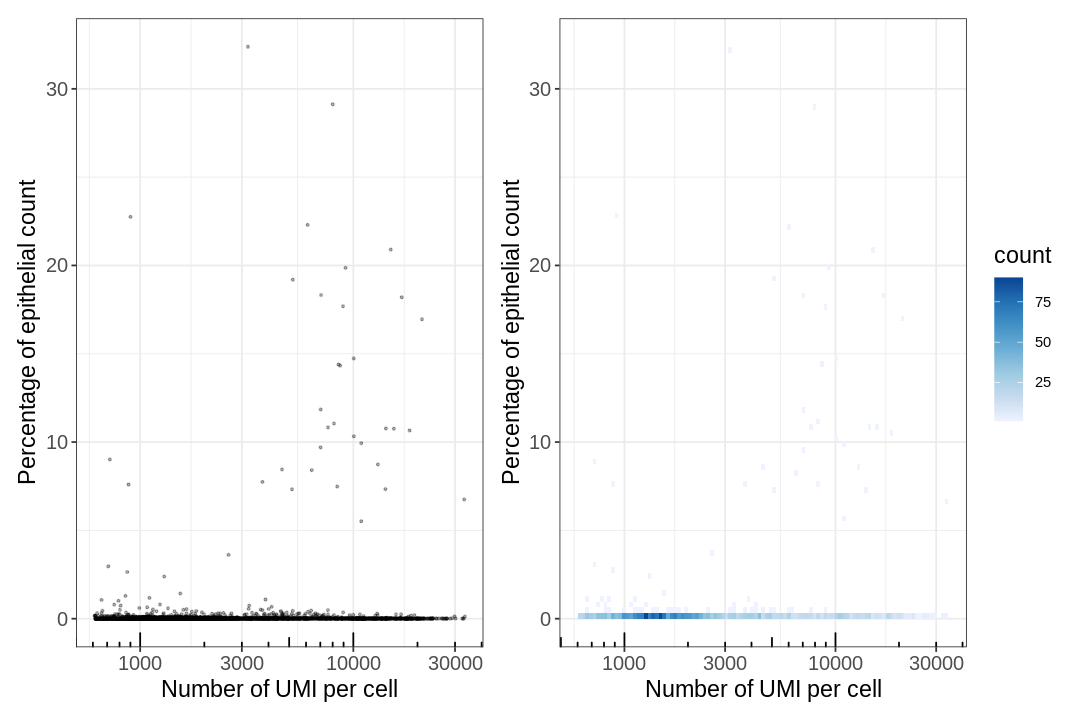

In [0]:
epithelial <- c("PLA2G2A", "CLCA1", "REG4", "S100A14", "ITLN1", "ELF3", "PIGR", "EPCAM", "REG1B", "REG1A", "REG3A", "FABP1", "RBP2", "SST", "FABP2", "SPINK1", "FABP6", "AGR2", "AGR3", "CLDN3", "CLDN4", "DEFA6", "DEFA5", "SPINK4", "ALDOB", "LCN2", "MUC2", "KRT8", "KRT18", "TSPAN8", "OLFM4", "GPX2", "IFI27", "PHGR1", "MT1G", "CLDN7", "KRT19", "FXYD3", "LGALS4", "FCGBP", "TFF3", "TFF1")
seu$pct_epi <- PercentageFeatureSet(seu, features = epithelial)
plot_scatter_density(seu, features = c("nCount_RNA", "pct_epi"), 
                     log = "x", alpha = 0.3,
                     xlab = ncount_lab, 
                     ylab = "Percentage of epithelial count")

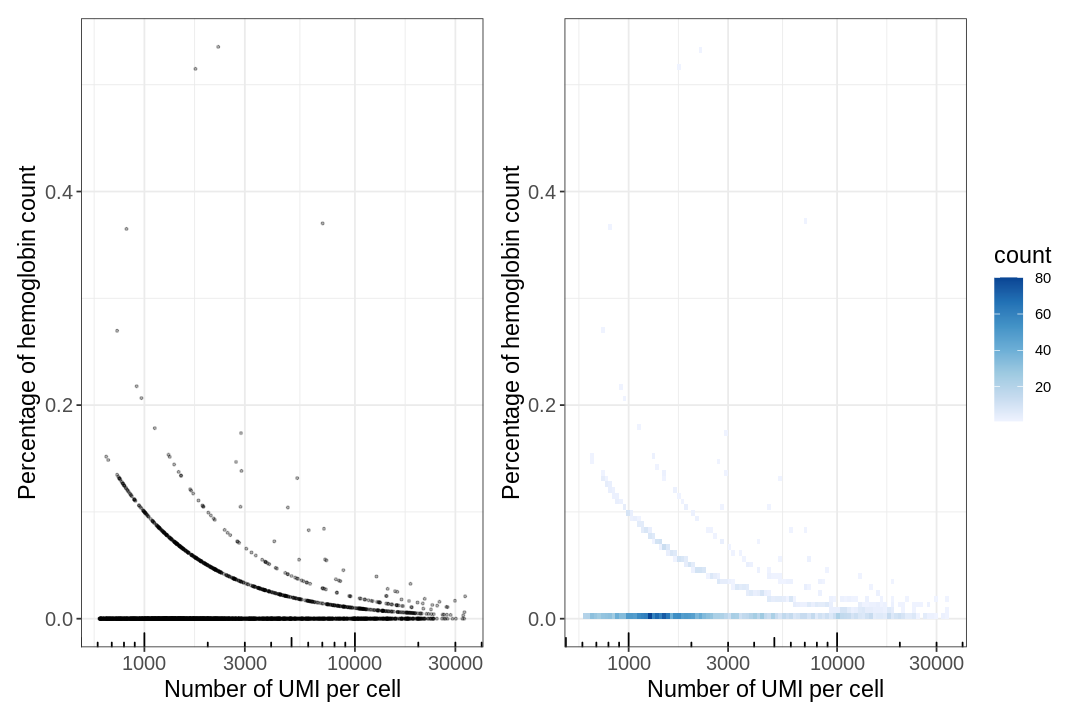

In [0]:
seu$pct_hb <- PercentageFeatureSet(seu, pattern = "^HB")
plot_scatter_density(seu, features = c("nCount_RNA", "pct_hb"), 
                     log = "x", alpha = 0.3,
                     xlab = ncount_lab, ylab = "Percentage of hemoglobin count")

While there seem to be some epithelial cells, all cells in this dataset have very low percentage of hemoglobin counts.

In [0]:
seu <- seu[, seu$pct_epi < 1]

How many cells are there left?

In [0]:
seu

An object of class Seurat 
30524 features across 2918 samples within 1 assay 
Active assay: RNA (30524 features)

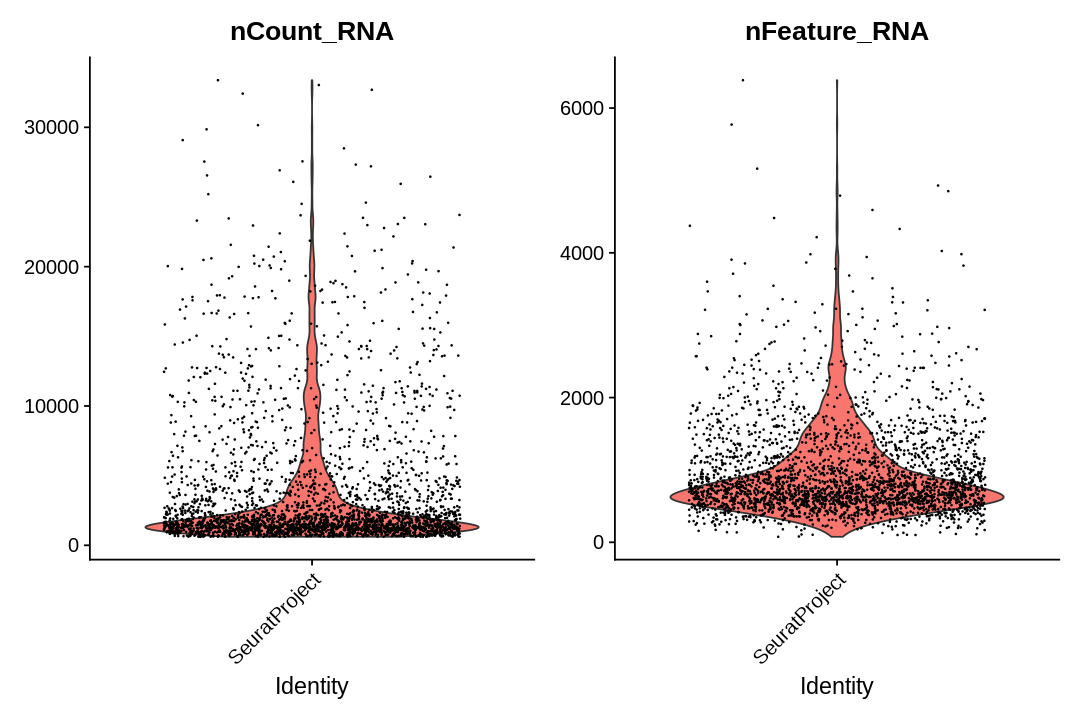

In [0]:
VlnPlot(seu, c("nCount_RNA", "nFeature_RNA"), pt.size = 0.1)

## Exploratory data analysis
`SCTransform` is used to normalize and scale data and find highly variable genes. This can replace `NormalizeData() %>% ScaleData() %>% FindVariableFeatures()`.

In [0]:
seu <- suppressWarnings(SCTransform(seu, verbose = FALSE))

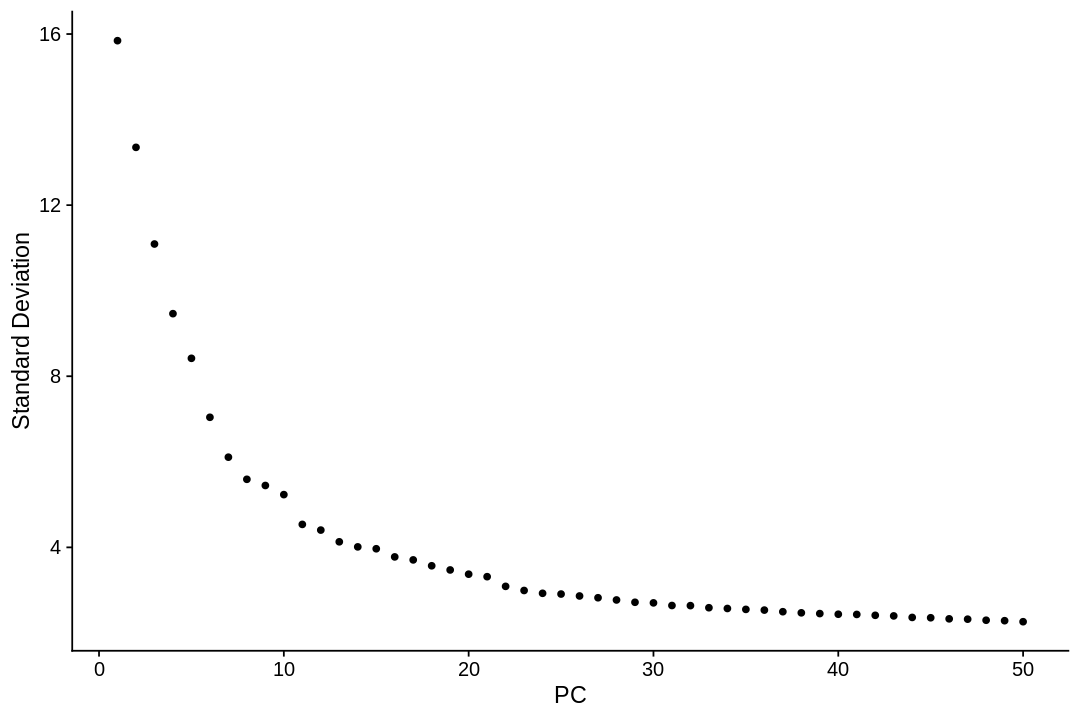

In [0]:
seu <- RunPCA(seu, npcs = 50, verbose = FALSE)
ElbowPlot(seu, 50)

Use 20 PCs for downstream analyses.

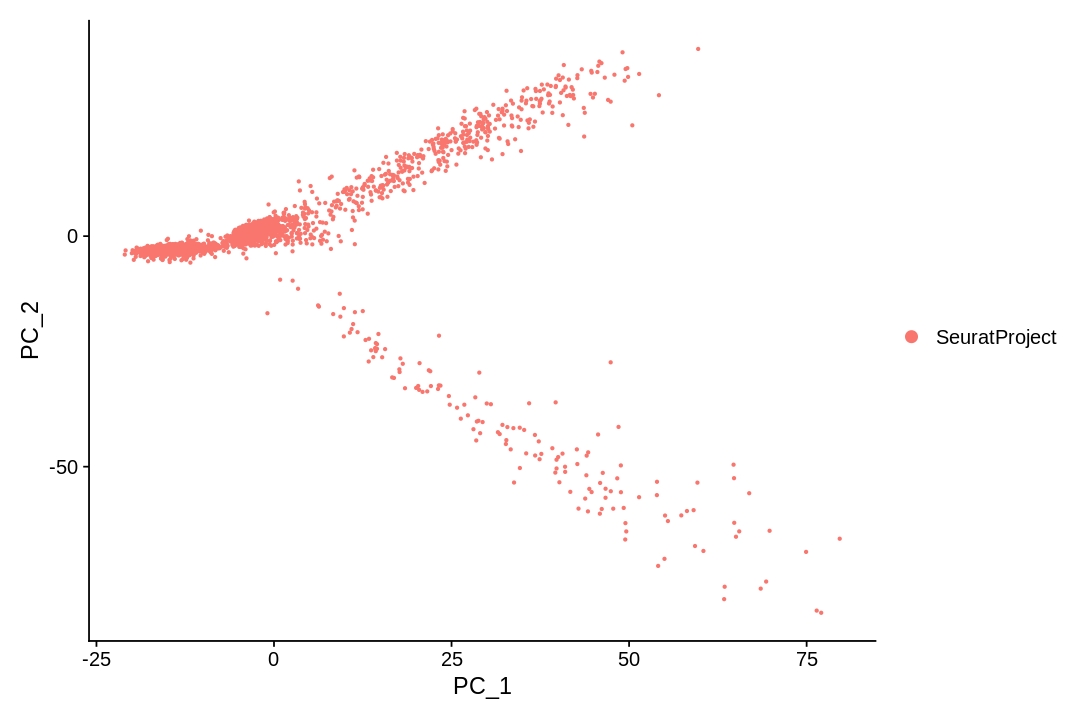

In [0]:
PCAPlot(seu)

Which genes are contributing the most the top PCs?

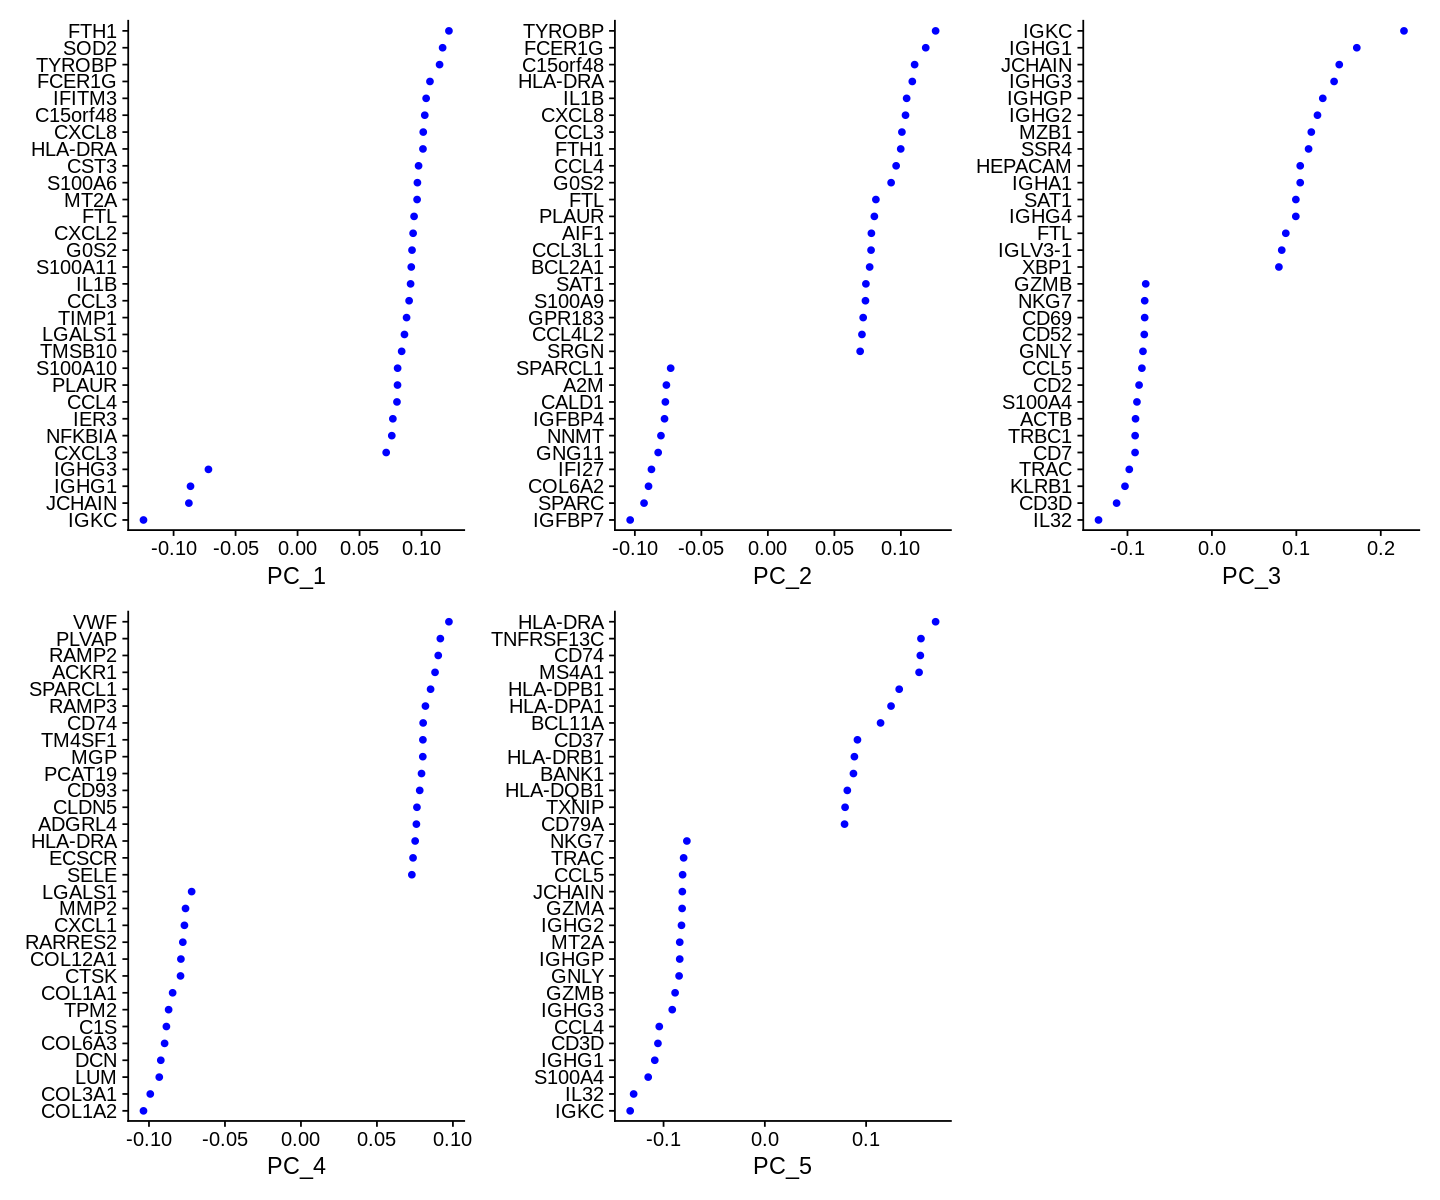

In [0]:
options(repr.plot.width=12, repr.plot.height=10)
VizDimLoadings(seu, ncol = 3)

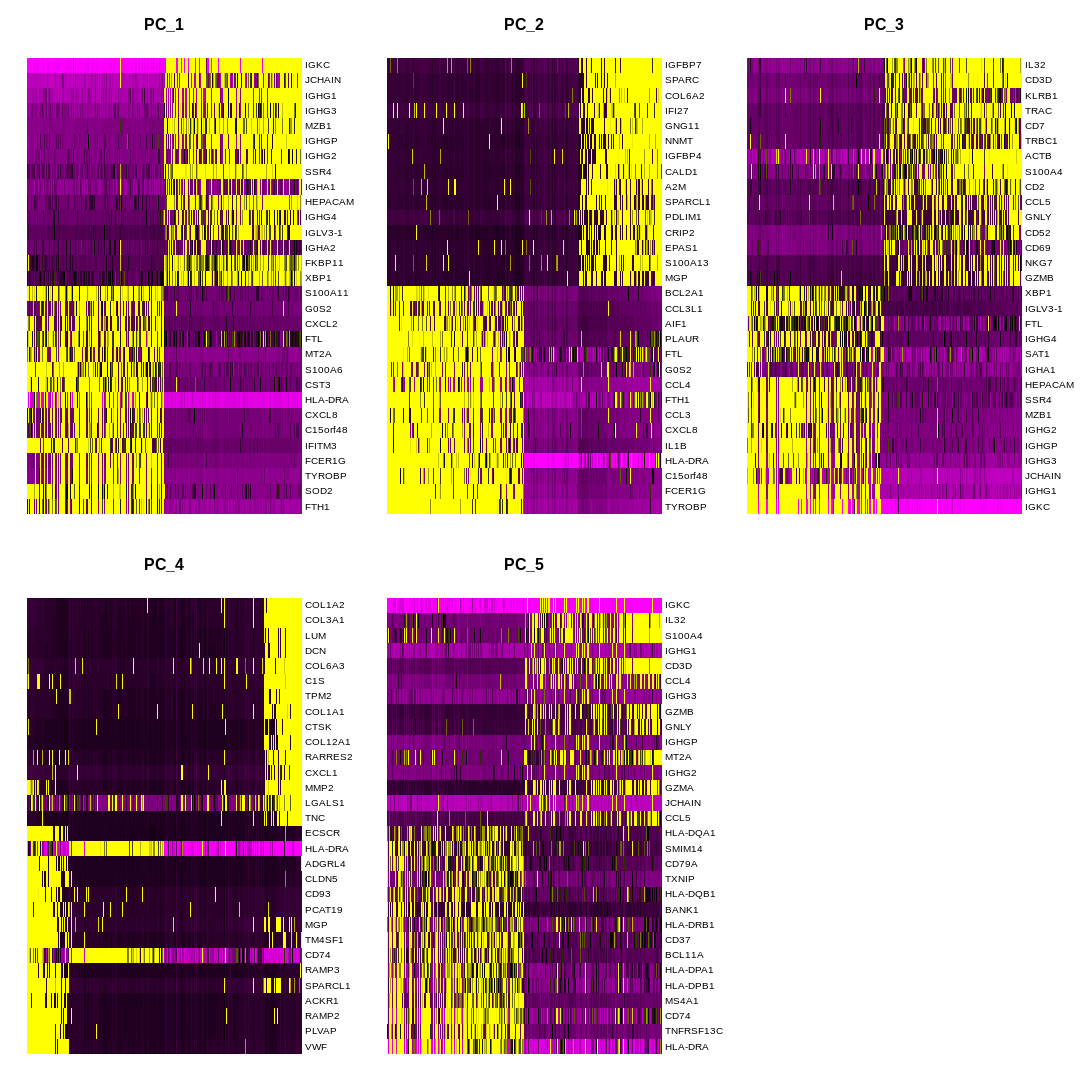

In [0]:
options(repr.plot.width=9, repr.plot.height=9)
DimHeatmap(seu, dims = 1:5, ncol = 3, cells = 500, balanced = TRUE)

Leiden clustering

In [0]:
seu <- FindNeighbors(seu, dims = 1:20, verbose = FALSE)
seu <- FindClusters(seu, algorithm = 4, verbose = FALSE, resolution = 1)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


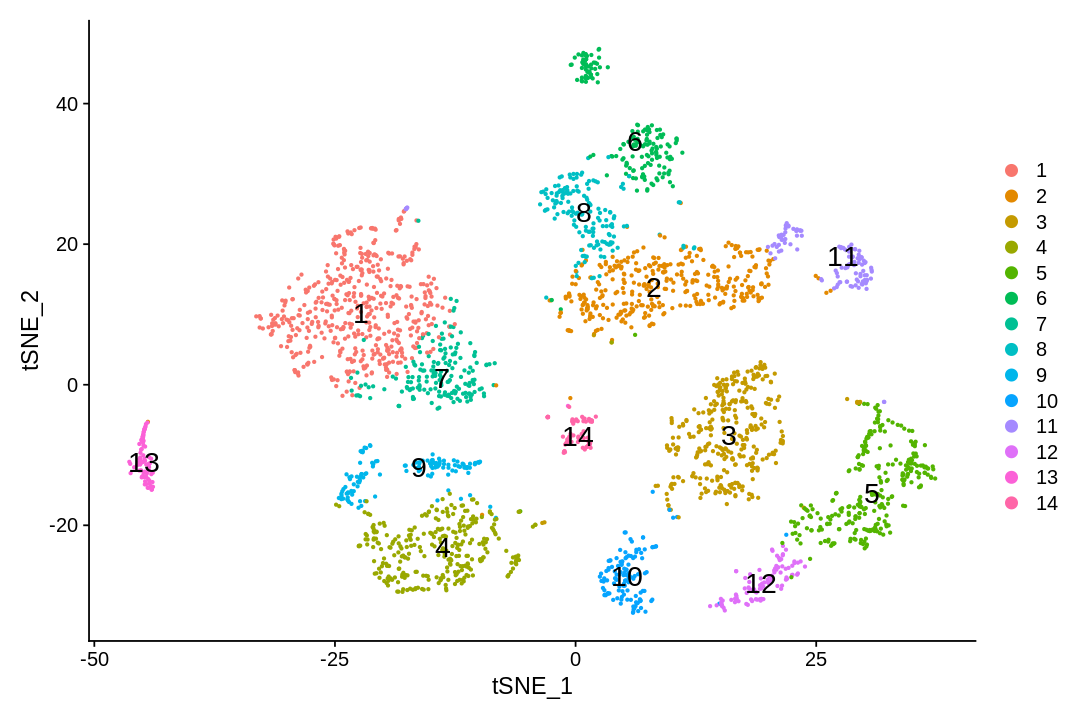

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
seu <- RunTSNE(seu, dims = 1:20)
TSNEPlot(seu, label = TRUE, label.size = 6)

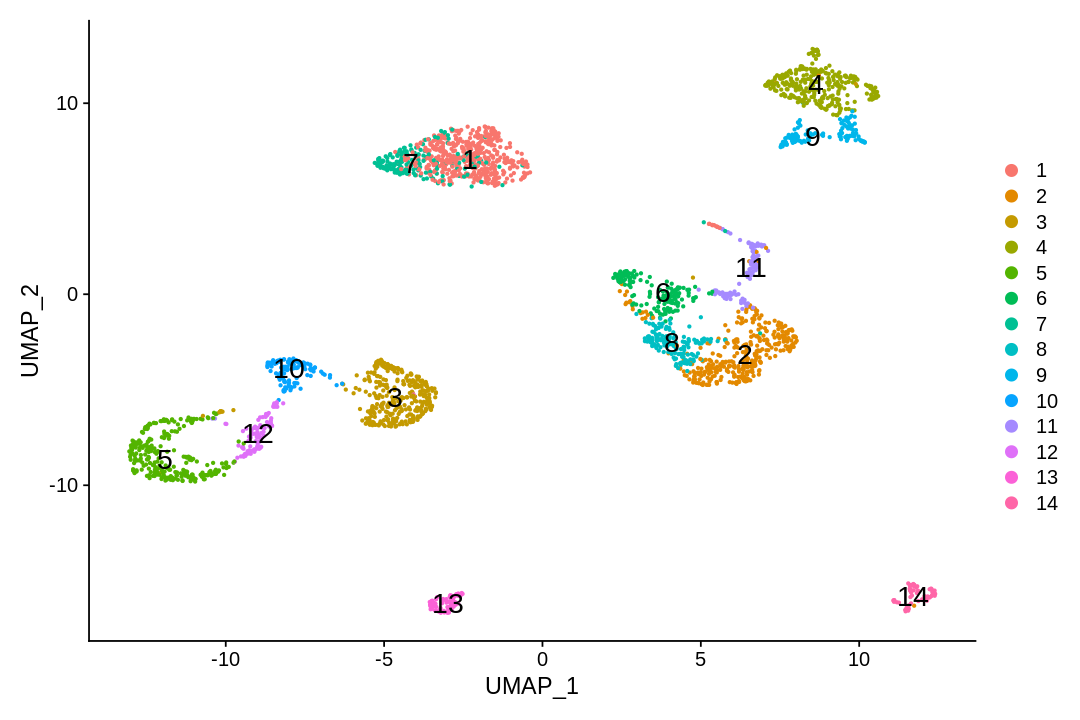

In [0]:
seu <- RunUMAP(seu, dims = 1:20, verbose = FALSE)
UMAPPlot(seu, label = TRUE, label.size = 6)

## Differential expression
What types of cells are there in those clusters? One of the ways to answer this question is differential expression, i.e. to find which genes are differentially expressed between clusters. There're many different methods of DE, such as Wilcoxon rank sum test, which is the default in Seurat. Other methods provided by Seurat include Student's t test, area under the receiver operator curve, logistic regression likelihood ratio test, [MAST](http://bioconductor.org/packages/release/bioc/html/MAST.html), and [DESeq2](http://bioconductor.org/packages/release/bioc/html/DESeq2.html). Here we use the logistic regression method, which was introduced in 

Ntranos, V., Yi, L., Melsted, P. et al. A discriminative learning approach to differential expression analysis for single-cell RNA-seq. Nat Methods 16, 163–166 (2019).

In [0]:
markers <- suppressWarnings(FindAllMarkers(seu, test.use = "LR", min.pct = 0.2, 
min.diff.pct = 0.2, verbose = FALSE)) 

Plot the most differentially expressed (DE) genes of each cluster

In [0]:
top_markers <- markers %>% 
  group_by(cluster) %>% 
  top_n(1, -p_val) %>% 
  pull(gene)

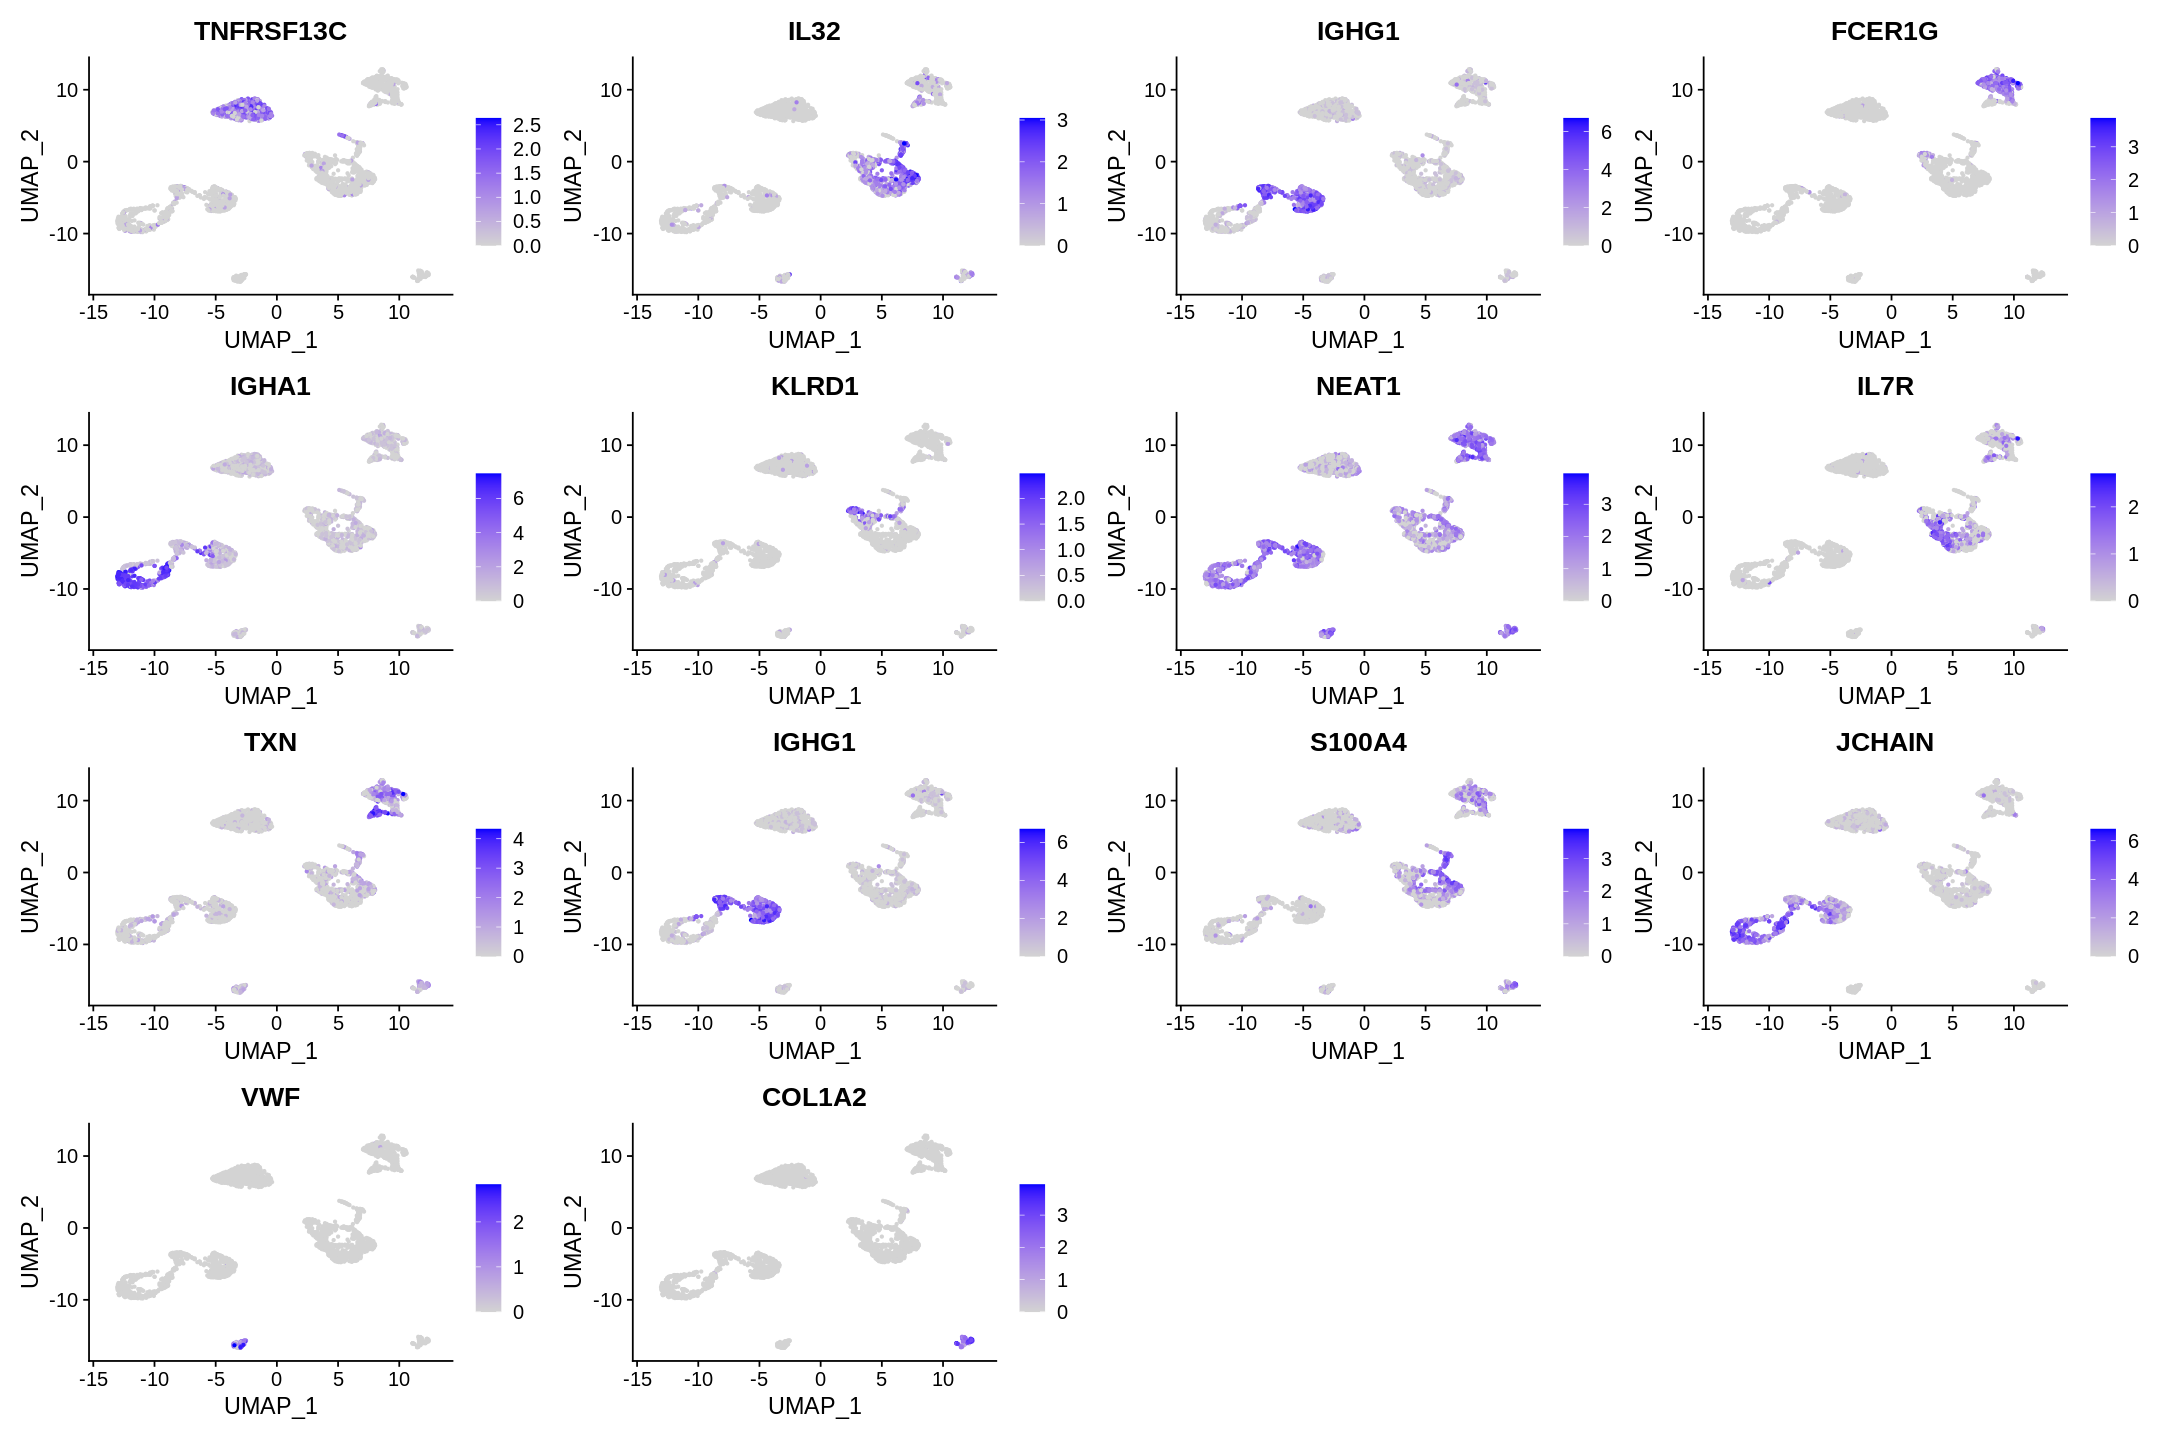

In [0]:
options(repr.plot.width=18, repr.plot.height=12)
FeaturePlot(seu, top_markers, reduction = "umap")

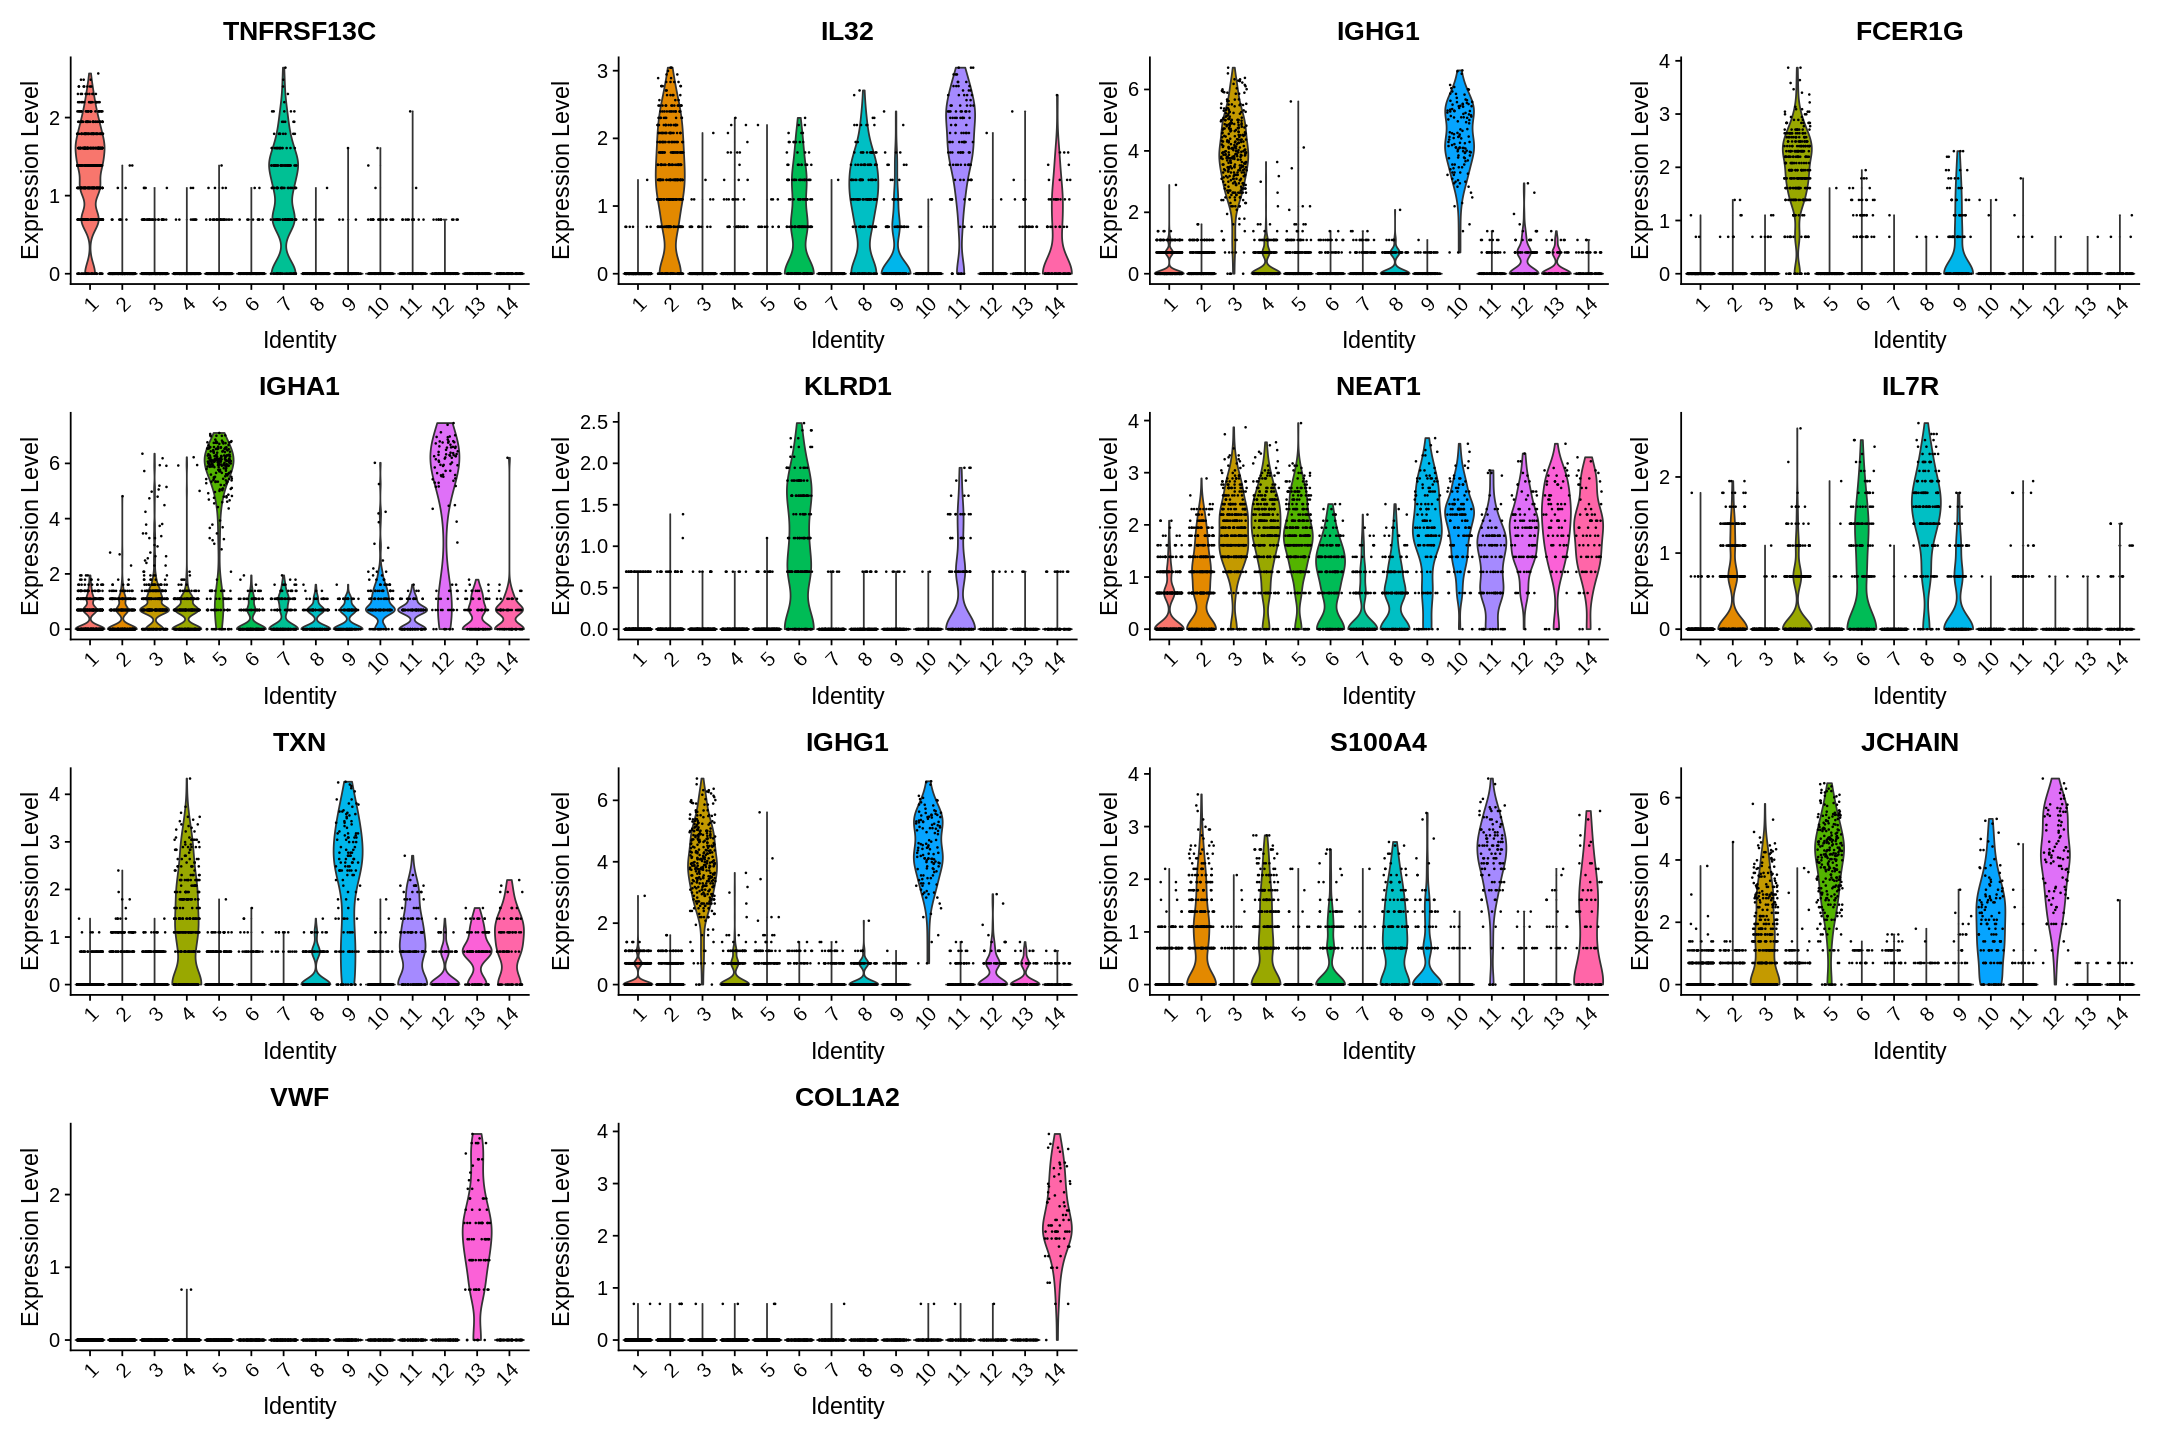

In [0]:
VlnPlot(seu, top_markers, pt.size = 0.1)

See more DE genes for each cluster

In [0]:
top_genes2 <- markers %>% 
  group_by(cluster) %>% 
  top_n(5, -p_val_adj) %>% 
  pull(gene) %>% unique()

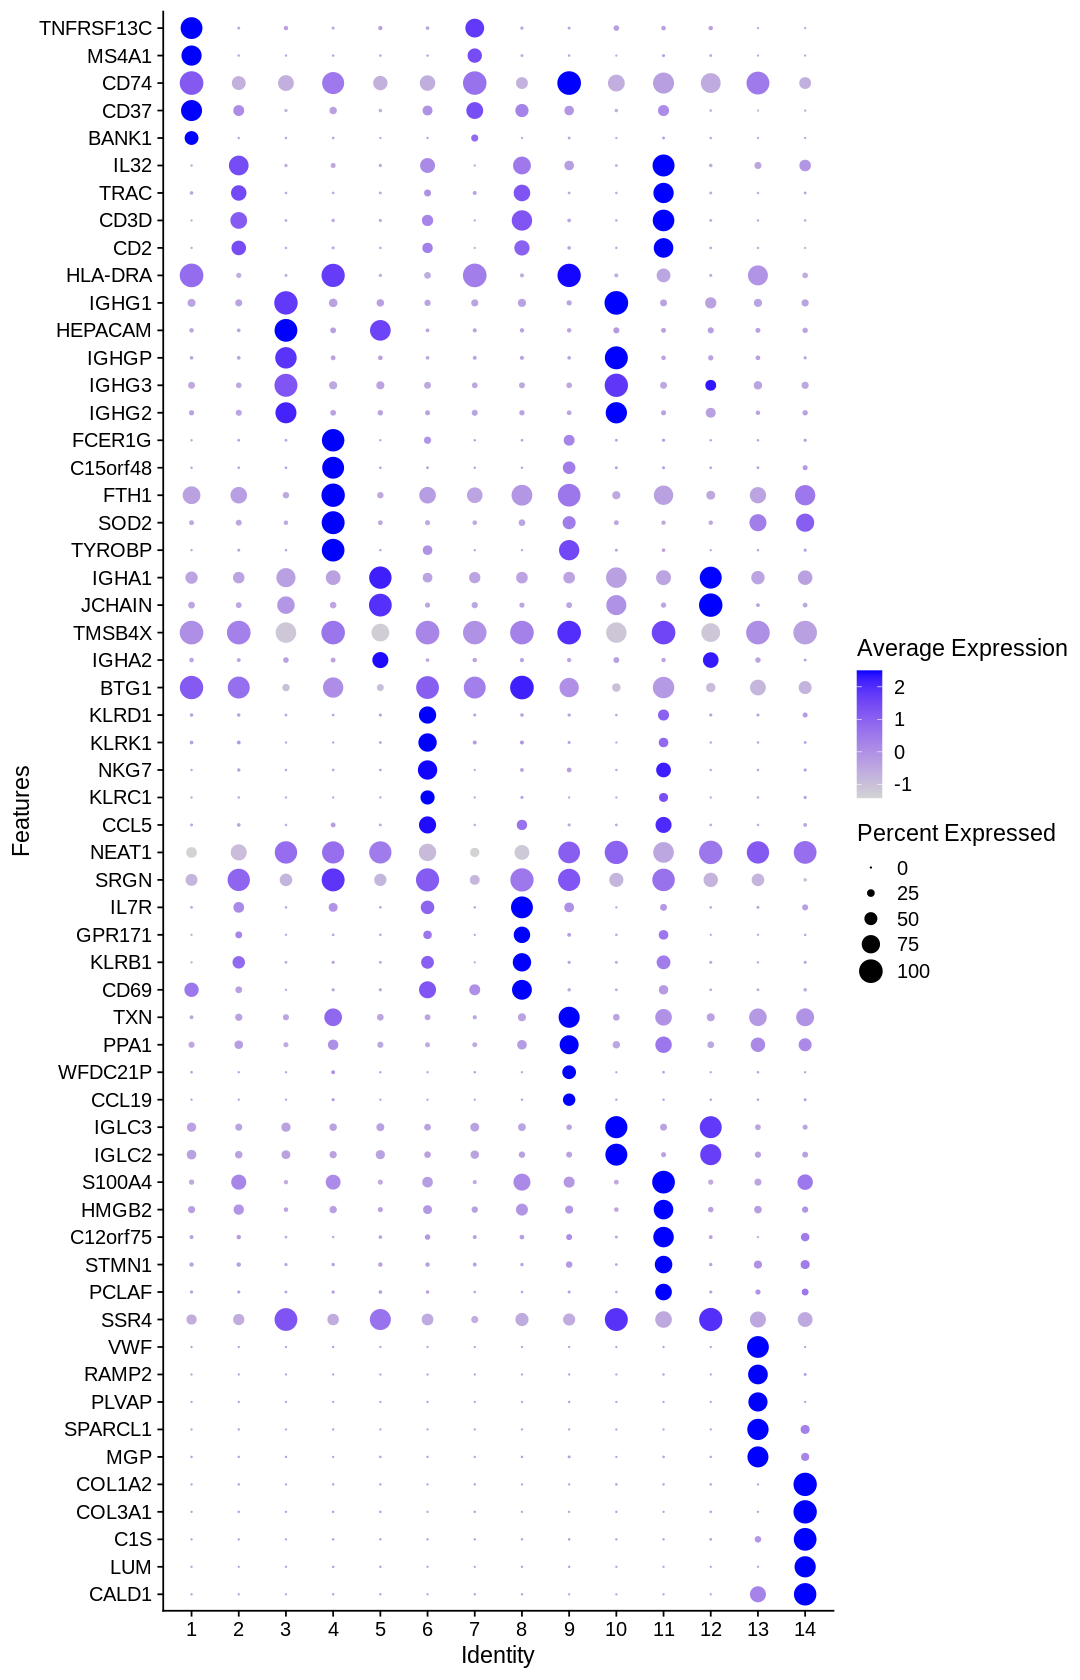

In [0]:
options(repr.plot.width=9, repr.plot.height=14)
DotPlot(seu, features = top_genes2) +
  coord_flip()

Clusters 2, 8, and 11 highly express T cell markers IL32, CD3D, TRAC, and CD2. Compared to cluster 2, cluster 11 also highly expresses cell cycle related genes such as S100A4 and HMGB2. STMN1 destabilizes microtubules. Increased expression of GAPDH here might mean increased glycolysis. Expression of GNLY, which encodes a protein in cytotoxic granules of T cells, suggests that cluster 11 is cytotoxic T cells. Cluster 8 expresses the activation marker CD69 and natural killer cell marker KLRB1; I guess it's activated T cells. 

Clusters 1 and 7 highly express B cell markers MS4A1, TNFRSF13C, CD37, and CD79A.

Clusters 3 and 10 highly express genes encoding IgG heavy chain. Unlike cluster 10, cluster 3 expresses cell adhesion gene HEPACAM, while cluster 10 also expresses genes encoding constant regions of immunoglobin light chains. Cluster 12 expresses genes encoding IgA heavy chain besides those for the light chain constant regions. So clusters 3 and 10 would be annotated as IgG B cells and cluster 11 IgA B cells. Cluster 5 seems related; it highly expresses genes encoding IgA heavy chain but not the constant region in light chain.

Clusters 4 and 9 seem to be involved in some redox reactions.

## Cell type annnotation
There are well-known marker genes for many cell types, which can help us to annotate cell types for clusters. More recently, methods have been developed to use existing data with annotated cell types as references to annotate new datasets. Such methods include [`SingleR`](http://bioconductor.org/packages/release/bioc/html/SingleR.html) and [`Garnett`](https://cole-trapnell-lab.github.io/garnett/). Here the known marker genes are used for a simple annotation.

In [0]:
markers_init <- tribble(
  ~ cell_type, ~ gene,
  "T cell", c("CD3D", "CD2", "CD7"),
  "ILC", c("CD2", "CD7", "GZMB", "KIT"),
  "Plasma cells", c("TNFRSF17", "MZB1"),
  "B cells", c("BANK1", "CD79B", "CD22", "MS4A1", "HLA-DRB1", "HLA-DQA1"),
  "MNP", c("HLA-DRB1", "HLA-DQA1", "LYZ"),
  "pDC", c("IL3RA", "IRF7", "GZMB", "LILRA4", "CLEC4C"),
  "Mast cells", c("TPSAB1", "CMA1", "KIT"),
  "Stroma/glia", c("PLVAP", "VWF", "LYVE1", "CCL21", "COL3A1", "COL1A1", 
                   "ACTA2", "GPM6B", "S100B")
) %>% 
  unnest(cols = "gene")

ILC stands for innate lymphoid cells, MNP stands for mononuclear phagocytes, and pDC stands for plasmacytoid dendritic cells.

In [0]:
#' Use hierarchical clustering to reorder rows in dot plots
#' 
#' @param df Data frame used for dot plot, with two categorical columns for the
#' x and y axes.
#' @param method Method of hierarchical clustering, passed to \code{hclust}.
#' @param key Column name in \code{df} for the variable to be reordered.
#' @param value Column name for the values to use to cluster \code{key}.
#' @param group Column name of the categorical variable used in plotting but not
#' reordered.
#' @return A tibble with \code{key} reordered according to \code{hclust}.
hclust_gene_df <- function(df, method = "complete", 
                           key = "gene", value = "value", group = "group") {
  # df is data frame of mean expression of genes in each cluster for one cell type
  # Skip if there're 1 or 2 genes
  n_genes <- length(unique(df[[key]]))
  if (n_genes < 3) {
    return(df)
  }
  df2 <- df %>% 
    select(!!group, !!key, !!value) %>% 
    pivot_wider(names_from = all_of(key), values_from = all_of(value))
  d <- df2 %>% select(-!!group) %>% as.matrix() %>% t() %>% dist()
  clust_res <- hclust(d, method)
  df2 <- df2[, c(1, clust_res$order + 1)] %>% 
    pivot_longer(cols = -!!group, names_to = key, values_to = value) %>% 
    select(-!!value) %>% 
    left_join(df, by = c(group, key))
  df2
}

In [0]:
#' A cooler version of Seurat's DotPlot
#' 
#' This function splits marker genes of different cell types into facets and 
#' does the same color scaling as Seurat does. In addition, it can cluster the
#' genes within each cell type to make the plot more visually appealing. The 
#' code for rearranging genes within each facet was adapted from \code{tidytext}.
#'
#' @param seu Seurat object
#' @param cell_type_df A data frame with a column \code{cell_type} and a column
#' \code{gene} for known marker genes of each cell type.
#' @param group.by Just like in Seurat's plot functions, the meta.data column to
#' split the cells on the x axis of the plot. By default, this is the current
#' \code{Idents} of \code{seu}.
#' @param col.min Any value below this will be cut off here to preserve dynamic
#' range of colors.
#' @param col.max Any value above this will be cut off here to preserve dynamic
#' range of colors.
#' @param do_hclust Logical, whether to cluster the genes.
#' @param method Method of hierarchical clustering, passed to \code{hclust}.
#' Ignored if \code{do_hclust = FALSE}.
CellTypeDotPlot <- function(seu, cell_type_df, group.by = NULL, col.min = -2.5,
                            col.max = 2.5, do_hclust = TRUE, method = "complete") {
  genes_use <- intersect(cell_type_df$gene, rownames(GetAssayData(seu)))
  df <- FetchData(seu, genes_use)
  if (is.null(group.by)) {
    df$group <- Idents(seu)
  } else {
    df$group <- seu@meta.data[[group.by]]
  }
  df <- df %>% group_by(group)
  mean_expr <- df %>% 
    summarize_all(function(x) mean(expm1(x)))
  pct_expr <- df %>% 
    summarize_all(function(x) mean(x > 0) * 100) %>% 
    gather(key = "gene", value = "pct_expr", -group)
  # Scale the mean expressions within each cluster
  mean_expr_scaled <- t(scale(t(as.matrix(select(mean_expr, -group)))))
  mean_expr_scaled[mean_expr_scaled > col.max] <- col.max
  mean_expr_scaled[mean_expr_scaled < col.min] <- col.min
  mean_expr_scaled <- as_tibble(mean_expr_scaled)
  mean_expr_scaled$group <- mean_expr$group
  mean_expr_scaled <- mean_expr_scaled %>% 
    gather(key = "gene", value = "mean", -group) %>% 
    left_join(cell_type_df, by = "gene") %>% 
    left_join(pct_expr, by = c("group", "gene")) %>% 
    mutate(clust_use = mean * pct_expr)
  if (do_hclust) {
    mean_expr_scaled <- mean_expr_scaled %>% 
      group_by(cell_type) %>% 
      group_nest() %>% 
      mutate(reordered = map(data, hclust_gene_df, 
                             method = method, key = "gene", 
                             value = "clust_use")) %>% 
      select(-data) %>% 
      unnest(cols = "reordered")
    # Prepare data frame for rearranging genes within each facet
    mean_expr_scaled <- mean_expr_scaled %>% 
      mutate(g = factor(paste(gene, cell_type, sep = "__"),
                        levels = unique(paste(gene, cell_type, sep = "__"))))
  } else {
    mean_expr_scaled <- mean_expr_scaled %>% 
      rename(g = gene)
  }
  p <- ggplot(mean_expr_scaled, aes(group, g)) +
    geom_point(aes(color = mean, size = pct_expr), alpha = 0.8) +
    scale_color_distiller(palette = "Blues", direction = 1, name = "Average\nExpression") +
    scale_size_area(name = "Percent\nExpressed") +
    facet_grid(rows = vars(cell_type), scales = "free_y", space = "free_y") +
    labs(x = "Identity", y = "Features") +
    theme(legend.position = "top",
          axis.text = element_text(size = 12),
          strip.text = element_text(size = 12),
          axis.title = element_text(size = 14),
          legend.title = element_text(size = 14))
  if (do_hclust) {
    p <- p +
      scale_y_discrete(label = function(x) gsub("__.+$", "", x))
  }
  p
}

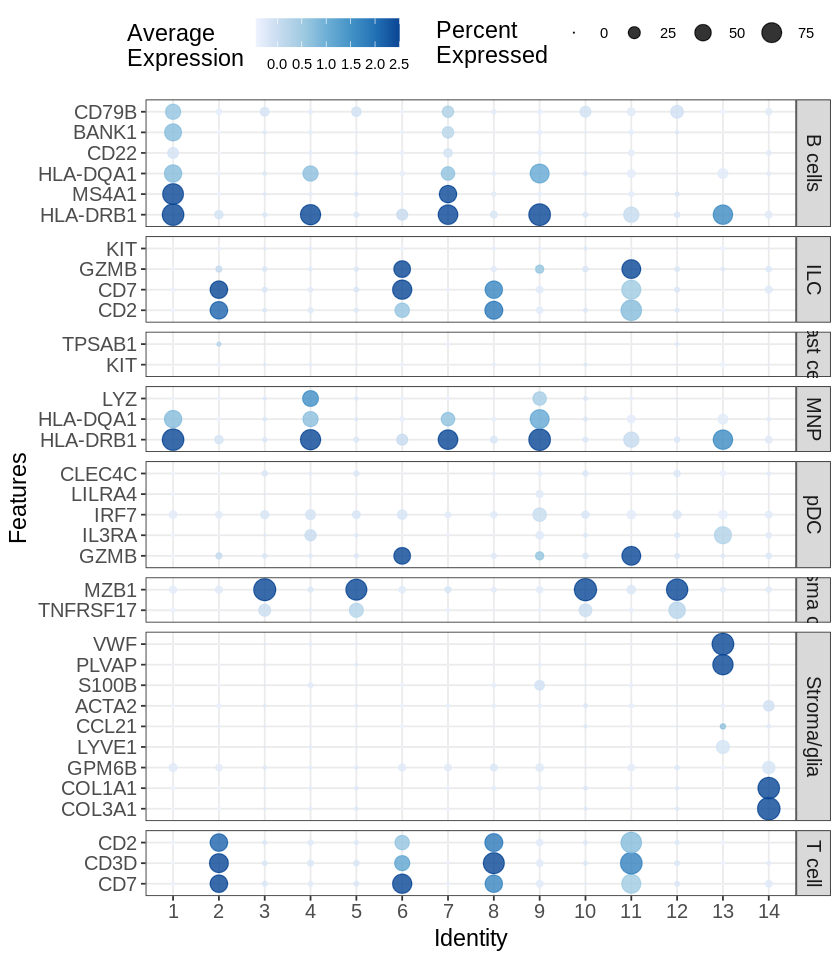

In [0]:
options(repr.plot.width=7, repr.plot.height=8)
CellTypeDotPlot(seu, markers_init)

Now it seems that clusters 1 and 7 are some sort of B cells, clusters 2, 6, 8, and 11 are some sort of T cells, and clusters 4 and 9 are some sort of MNP, perhaps macrophages. 

The authors of this paper used gene coexpression modules to annotate cell types at a higher resolution. Gene coexpression modules can be found by clustering the Pearson correlation matrix of the genes, but there are more sophisticated methods like [`WGCNA`](https://cran.r-project.org/web/packages/WGCNA/index.html), which was used by the Allen Brain Institute to find gene coexpression modules among the RNA-seq samples in the Allen Brain Atlas. Here are some of the higher resolution marker genes from the paper:

### Macrophages

In [0]:
macrophage <- tribble(
  ~ cell_type, ~ gene,
  "Resident macrophages", c("CD163L1", "LILRB5", "FOLR2", "FUCA1", "GPNMB", 
                            "APOC1", "LGMN", "STAB1", "SEPP1", "CSF1R", 
                            "MS4A4A", "SLC40A1", "SLCO2B1", "MAFB", "MRC1", 
                            "DAB2", "CD209", "DNASE1L3", "RGS2", "JAML", 
                            "VSIG4", "CPVL", "CLEC10A", "RNASE6"),
  "Inflammatory macrophages", c("CCL4L2", "CXCL2", "CXCL3", "CD83", "CXCL8", 
                                "SOD2", "TXN", "CCL3", "CCL3L3", "CCL4", "NFKBIA",
                                "CD44", "PKM", "S100A6", "IL1B", "PLAUR", "IER3",
                                "C15orf48", "G0S2", "S100A9", "S100A8")
) %>% 
  unnest(cols = "gene")

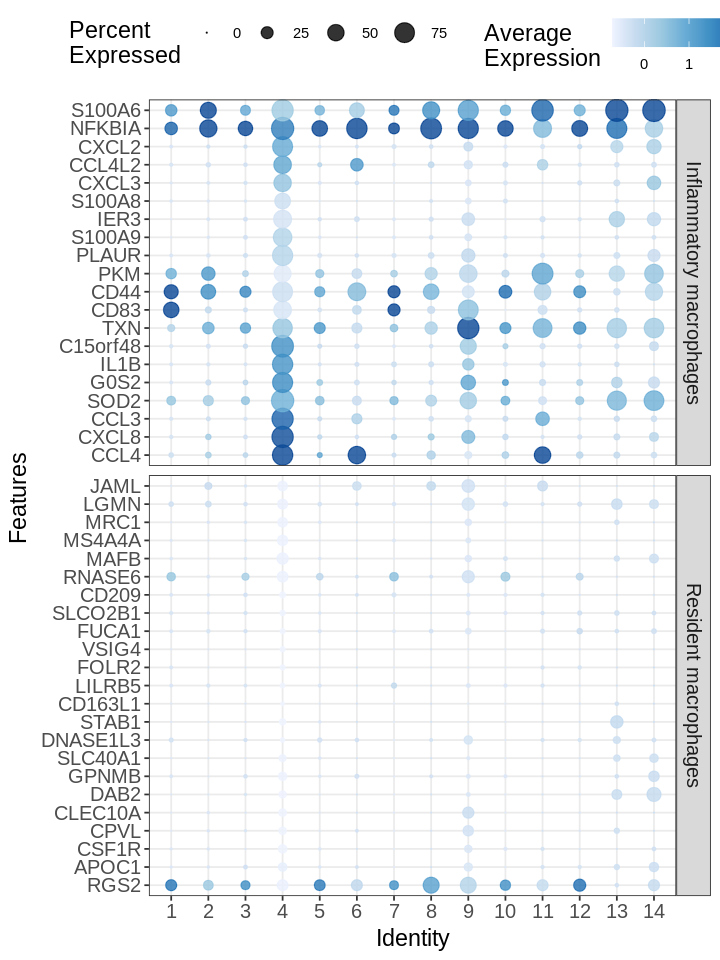

In [0]:
options(repr.plot.width=6, repr.plot.height=8)
CellTypeDotPlot(seu, macrophage)

Now it's clear that cluster 4 is inflammatory macrophages and there're few resident macrophages in this dataset. This makes sense, because this dataset is from a lesion rather than healthy tissue.

### Dendritic cells


In [0]:
dendritic <- tribble(
  ~ cell_type, ~ gene,
  "moDC", c("CD209", "MMP19", "STAB1", "DAB2", "PDK4", "SEPP1", "C5AR2", "MERTK",
            "ABHD5", "TFRC", "C1QC", "CD163", "CD207", "MRC1"),
  "DC2", c("CLEC10A", "FCER1A", "CD1D", "CFP", "CD1E", "CD1C", "LILRA5", 
           "CLEC4A", "FCGR2B", "FGR", "CASP1", "AVPI1", "FCN1"),
  "DC1", c("CPNE3", "CCND1", "S100B", "TMEM14A", "C1orf21", "UBE2C", "ENPP1", 
           "XCR1", "CADM1", "CPNES", "CLEC9A", "CLNK", "KIAA0101", "C1ORF54", "BATF3"),
  "Activated DC", c("IDO1", "MARCKS", "CCR7", "GPR157", "POGLUT1", "LAMP3", 
                    "CCL19", "CCL22", "CCL17", "EBI3", "CD274", "FSCN1", "DAPP1",
                    "ANXA6", "NUB1", "ERICH1", "TUBA1C", "KDM2B", "TNFAIP2", 
                    "GRSF1", "CD40", "CRIP1", "CD86", "IL7R", "MARCKSL1", 
                    "BIRC3", "ID2", "CFLAR", "CD83"),
  "pDC", c("IRF7", "IRF8", "PPP1R14B", "C12orf75", "ALOX5AP", "IL3RA", "TM2C", 
           "PTGDS", "CLIC3", "SCT", "GZMB", "TCL1A", "TCF4", "LILRA4")
) %>% 
  unnest(cols = "gene")

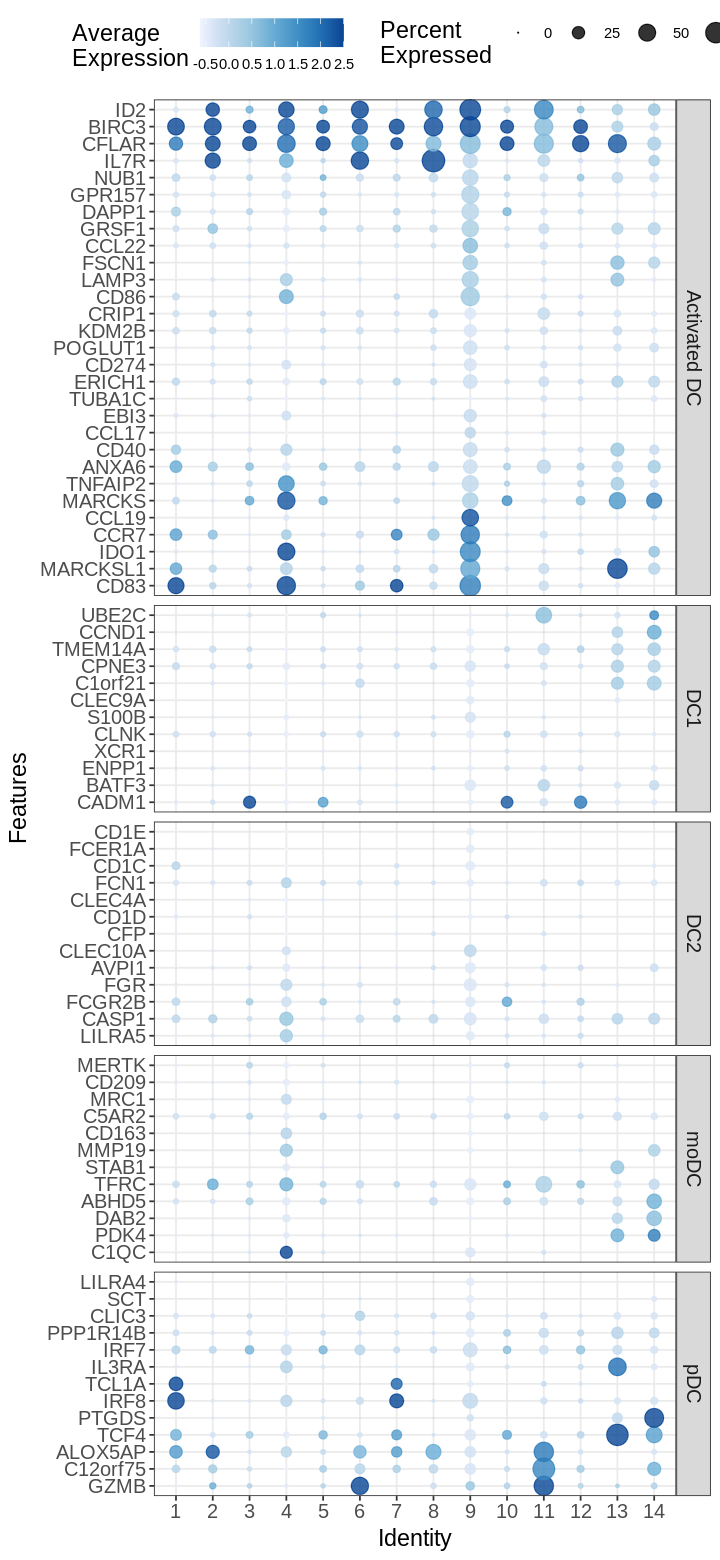

In [0]:
options(repr.plot.width=6, repr.plot.height=13)
CellTypeDotPlot(seu, dendritic)

Now it's clear that cluster 9 is activated DCs.

### Stromal cells

In [0]:
stromal <- tribble(
  ~ cell_type, ~ gene,
  "CD36+ EO", c("VWF", "RAMP3", "NPDC1", "JAM2", "PLVAP", "NOTCH4", "HSPG2", 
                "ESAM", "CYYR1", "CD93", "ICAM2", "S1PR1", "RAMP2", "CD36", 
                "CA4", "TMEM88", "FLT1"),
  "ACKR1+ EO", c("VWF", "RAMP3", "NPDC1", "JAM2", "PLVAP", "NOTCH4", "HSPG2", 
                "ESAM", "CYYR1", "CD93", "ICAM2", "S1PR1", "RAMP2", "SELP", 
                "SELE", "ACKR1", "DUSP23", "CXorf36"),
  "Lymphatics", c("PROX1", "MMRN1", "RELN", "ANGPT2", "CCL21", "LYVE1", "TFF3"),
  "Pericytes", c("RGS5", "NDUFA4L2"),
  "SM", c("ACTG2", "MYH11", "CXCL14"),
  "Fibroblasts", c("CXCL14", "ADH1B", "LUM", "TCF21", "ADAMDEC1", "CCL13", 
                   "CCL8", "ADAM28", "HAPLN1", "ABCA8", "CFD"),
  "Activated fibroblasts", c("CTSK", "MMP2", "LUM", "PTGDS", "THY1", "CHI3L1", 
                             "BGN", "PDPN", "CXCL2", "CXCL8", "TNFRSF12A"),
  "Glial", c("SOX2", "CADM1", "SORCS1", "LGI4", "ALDH1A1", "CAB39L", "NTM", 
             "ANK3", "PRIMA1", "HAND2", "GPM6B", "CRYAB", "SLC22A17", "ERBB3", 
             "CDH19", "TMEM71", "NRXN1", "S100B", "MPZ", "MYOT", "SCN7A", 
             "PLP1", "CNP", "SPP1", "AP1S2", "CLU")
) %>% 
  unnest(cols = "gene")

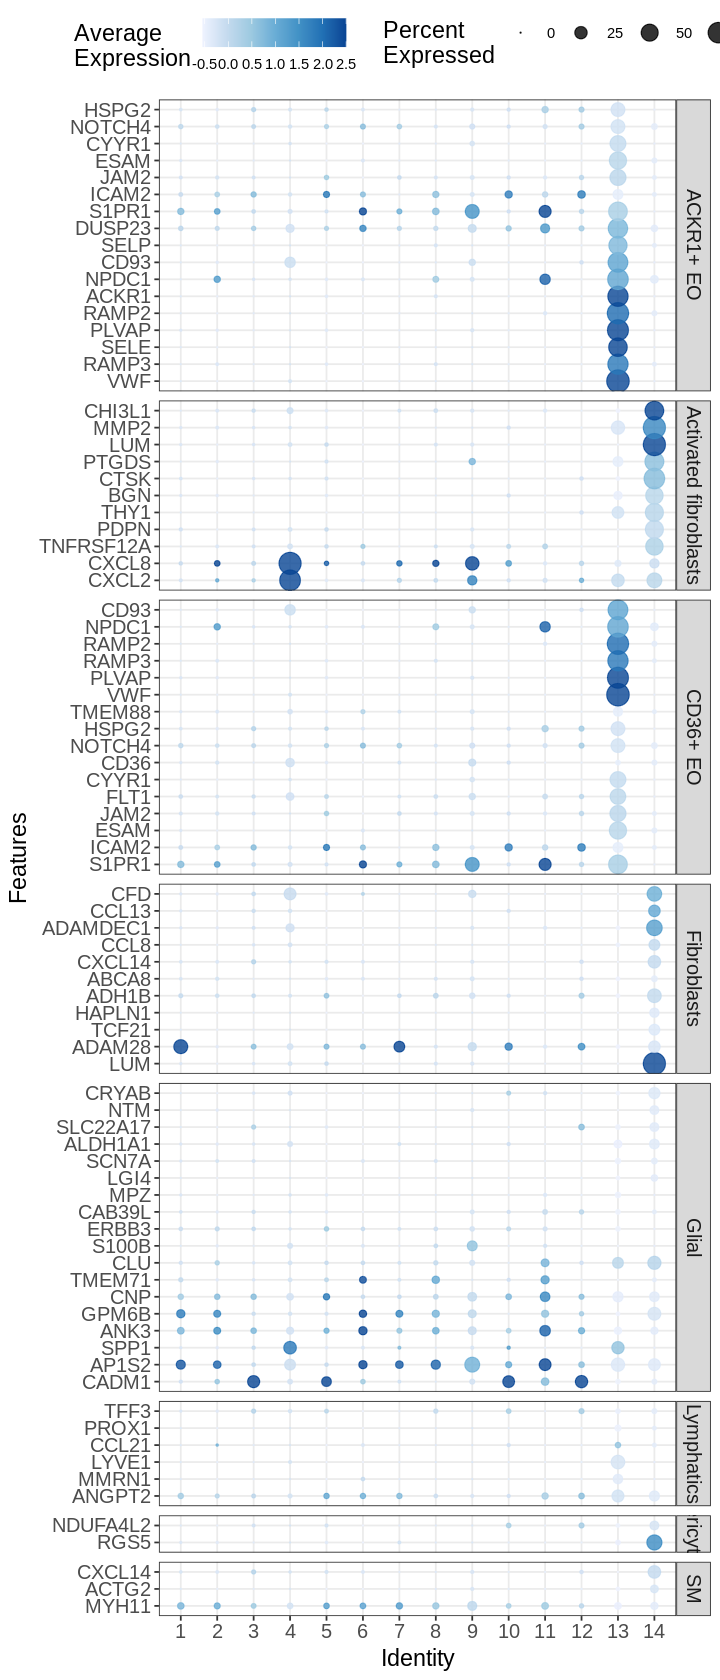

In [0]:
options(repr.plot.width=6, repr.plot.height=14)
CellTypeDotPlot(seu, stromal)

Now it's clear that cluster 13 is eosinophils and cluster 14 is fibroblasts, especially activated fibroblasts.

### B cells

In [0]:
B_cells <- tribble(
  ~ cell_type, ~ gene,
  "Plasma cells", c("JCHAIN", "MZB1", "SSR4", "XBP1", "FKBP2", "FKBP11", 
                    "TNFRSF17", "DERL3", "HSP90B1", "LGALS1", "SEC11C", 
                    "SDF2L1", "ITM2C", "PRDX4"),
  "IgA", "IGHA2",
  "IgM", "IGHM",
  "IgG", c("IGHG1", "IGHG3", "IGHGP", "IGHG4", "IGHG2"),
  "Memory B", c("CXCR4", "CD74", "HLA-DRA")
) %>% 
  unnest(cols = "gene")

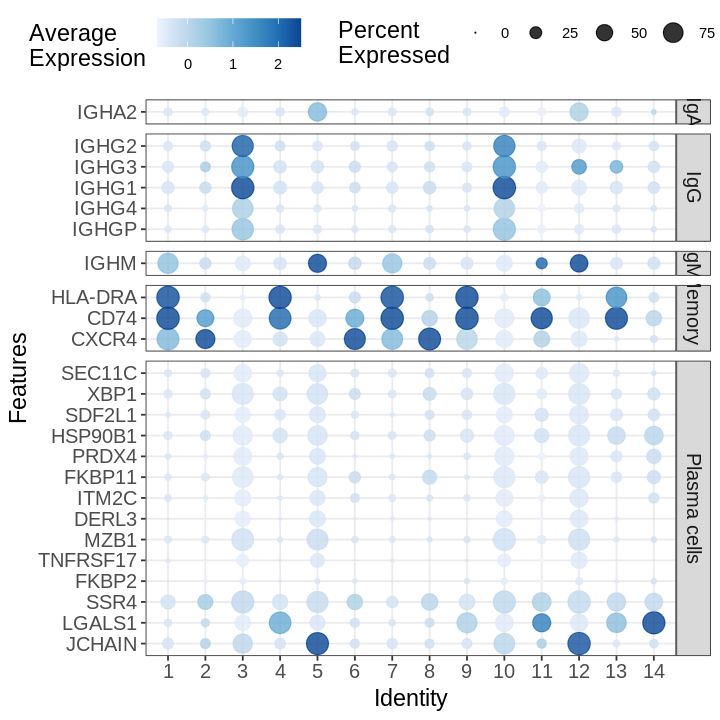

In [0]:
options(repr.plot.width=6, repr.plot.height=6)
CellTypeDotPlot(seu, B_cells)

Now it's clear that clusters 3 and 10 are IgG plasma cells. Clusters 1 and 7are memory B cells. Clusters 5 and 12 and IgA plasma cells.

### T cells

In [0]:
T_cells <- tribble(
  ~ cell_type, ~ gene,
  "T cells", c("CD7", "CD2", "CD3D", "LTB", "ID2"),
  "Highly activated T", c("STMN1", "KIAA0101", "PCNA", "ANP32E", "CKS1B", "RRM2",
                        "CENPF", "PTTG1", "TUBA1B", "TYMS", "UBE2C", "LSM4"),
  "Tregs", c("TNFRSF4", "TNFRSF18", "CTLA4", "IL2RA", "FOXP3", "IKZF2", "TIGIT",
             "ICA1", "CD27", "RBPJ"),
  "Naive T", c("BATF", "CCR7", "SELL", "LEF1", "CD28", "IL7R"),
  "Central memory T", c("BATF", "CCR7", "SELL", "LEF1", "CD28", "KLRB1"),
  "gamma delta Y", c("PASK", "TRDC", "TYROBP", "FCER1G", "XCL2", "XCL1", "GNLY"),
  "Cytotoxic T", c("KLRD1", "CCL5", "NKG7", "CCL4", "CCL4L2", "CMC1", "CST7", 
                 "GZMA", "GZMK"),
  "Type 1/3 cytokine Trm", c("KLRD1", "NKG7", "CCL4", "IFNG"),
  "CD8+ Trm", c("CD8A", "CD8B", "HOPX", "PTGER4", "DUSP1", "JUN", "FOS", "ZFP36",
                "KLF6", "KLRD1", "NKG7", "CCL4", "CD69", "ID2", "GPR171", "TNFAIP3", 
                "ANXA1", "IL7R", "KLRB1")
) %>% 
  unnest(cols = "gene")

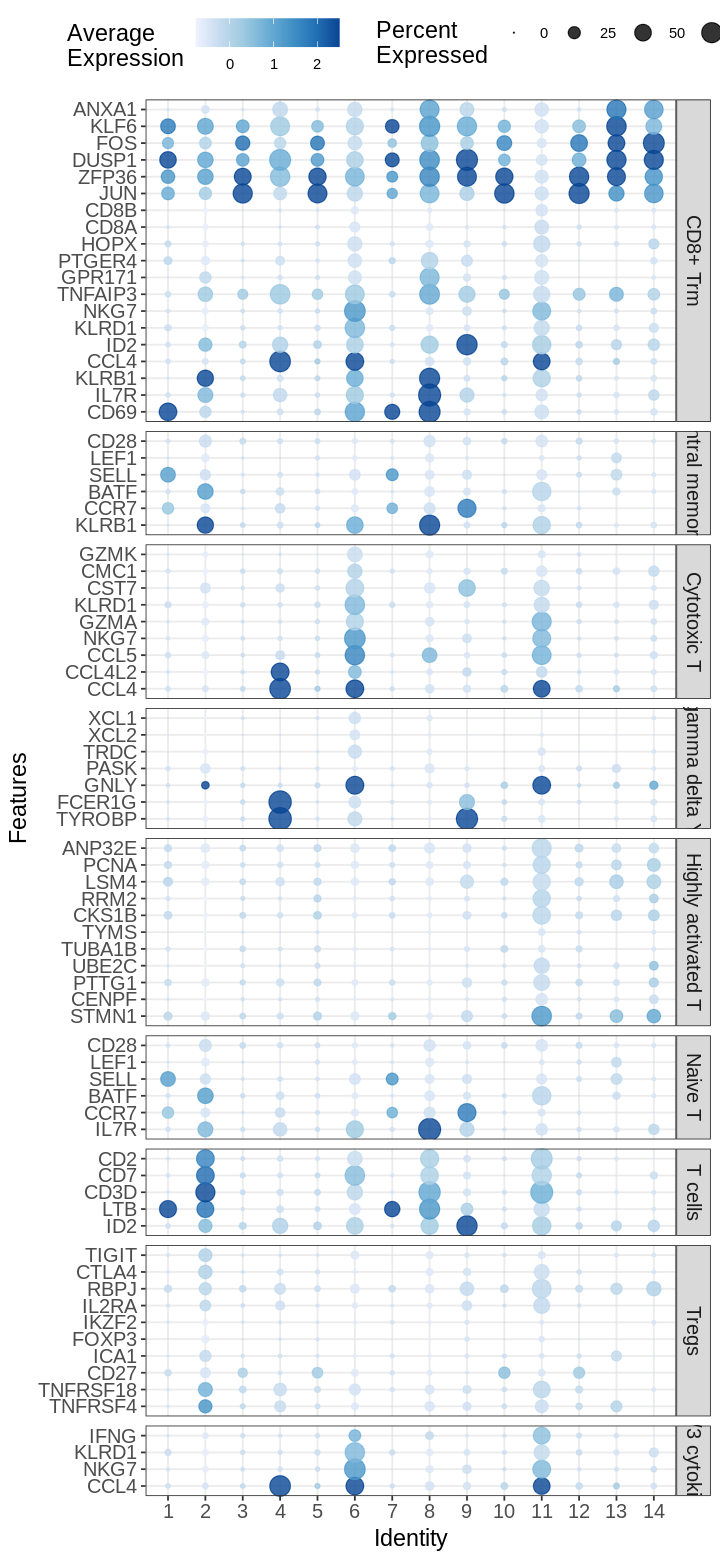

In [0]:
options(repr.plot.width=6, repr.plot.height=13)
CellTypeDotPlot(seu, T_cells)

Now it's clear that clusters 6 and 11 are cytotoxic T cells, but cluster 11 is highly activated. Clusters 2 and 8 are other types of T cells. 

### A basic GSEA
So far we've been eyeballing the expression of marker genes to annotate cell types. Is there a more quantitative and less subjective way? Yes. One of such ways is gene set enrichment analysis (GSEA), for which many packages have been written. Examples of such package are [`topGO`](http://bioconductor.org/packages/release/bioc/html/topGO.html), [`EGSEA`](http://bioconductor.org/packages/release/bioc/html/EGSEA.html), [`clusterProfiler`](http://bioconductor.org/packages/release/bioc/html/clusterProfiler.html), and [`gage`](http://bioconductor.org/packages/release/bioc/html/gage.html). 

Here we will implement a basic GSEA based on Fisher's exact test, testing for enrichment of each gene set among differentially expressed genes for each cluster. One of the places where the packages are more sophisticated than this is that gene sets often overlap and some of the packages can correct for this. However, Fisher's exact test can give us helpful information on cell type annotation.

Here the gene set is the known marker genes for each cell type used above. There are many resources for gene sets suitable for GSEA and much more comprehensive than the marker genes used above, such as [KEGG](https://www.genome.jp/kegg/pathway.html), [Gene Ontology (GO)](http://geneontology.org/), [Reactome](https://reactome.org/), and [Molecular Signature Database (MSigDB)](https://www.gsea-msigdb.org/gsea/msigdb/index.jsp). While KEGG, GO, and Reactome have gene set annotations for many species, MSigDB is only for human genes. The R packages mentioned above provide some commonly used gene sets. For non-model organisms, you might need to provide your own gene sets.

In [0]:
cell_types <- bind_rows(B_cells, T_cells, dendritic, macrophage, stromal)
gene_universe <- unique(cell_types$gene)
cell_types <- with(cell_types, split(gene, cell_type))

In [0]:
markers4gsea <- markers %>% 
  filter(p_val_adj < 0.05, gene %in% gene_universe) %>% 
  select(cluster, gene)
markers4gsea <- with(markers4gsea, split(gene, cluster))

In [0]:
gsea_res <- cross_df(list(cluster = names(markers4gsea), cell_type = names(cell_types)))
gsea_res <- gsea_res %>% 
  mutate(
    p_val = map2_dbl(cluster, cell_type, 
                     ~ fisher.test(x = gene_universe %in% cell_types[[.y]],
                                   y = gene_universe %in% markers4gsea[[.x]],
                                   alternative = "greater")$p.value),
    p_val_adj = p.adjust(p_val, method = "BH"),
    pct_genes = map2_dbl(cluster, cell_type, 
                         ~ length(intersect(markers4gsea[[.x]], cell_types[[.y]])) /
                           length(cell_types[[.y]]) * 100)
  )

In [0]:
# hclust the cell types to make it look better
gsea_plt <- hclust_gene_df(gsea_res, key = "cell_type", value = "p_val_adj",
                           group = "cluster") %>% 
  mutate(cluster = factor(cluster, levels = as.character(1:14)))

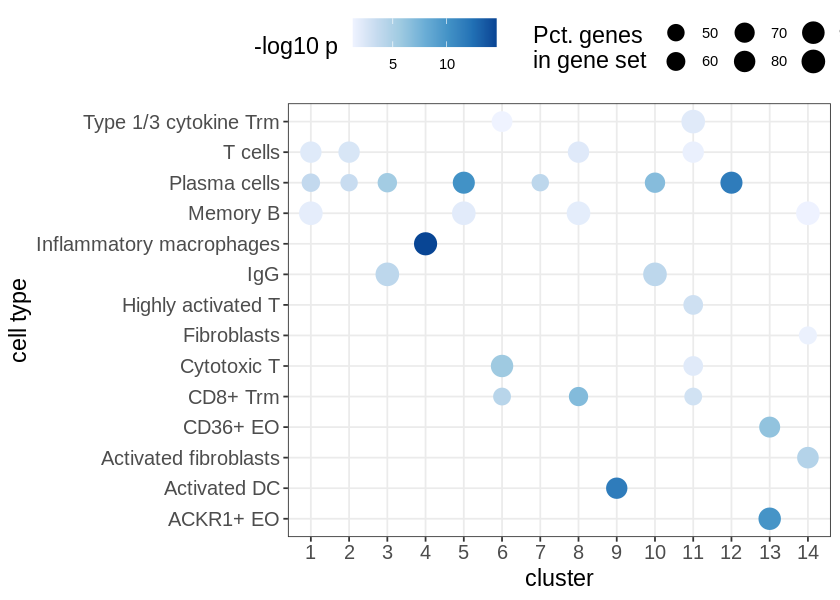

In [0]:
options(repr.plot.width=7, repr.plot.height=5)
gsea_plt %>% 
  filter(p_val_adj < 0.05) %>% 
  ggplot(aes(cluster, cell_type)) +
  geom_point(aes(color = -log10(p_val_adj), size = pct_genes)) +
  scale_color_distiller(palette = "Blues", direction = 1, 
                        name = "-log10 p") +
  scale_size_area(name = "Pct. genes\nin gene set") +
  theme(legend.position = "top",
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.title = element_text(size = 14)) +
  labs(y = "cell type")

IgA and IgM plasma cells did not appear here since those gene sets only have one gene, which makes the p value large, but from the plot for B cells, the presence of these cells is evident.

In [0]:
cell_type_annots <- tribble(
  ~ seurat_clusters, ~ cell_type,
  1, "Memory B",
  2, "T cells",
  3, "IgG",
  4, "Infl. macrophages",
  5, "IgA",
  6, "Cytotoxic T",
  7, "Memory B",
  8, "CD8+ Trm",
  9, "Activated DC",
  10, "IgG",
  11, "Highly activated T",
  12, "IgA",
  13, "Eosinophils",
  14, "Fibroblasts"
)
cell_type_annots <- cell_type_annots %>% 
  mutate(seurat_clusters = factor(seurat_clusters, levels = 1:14))

In [0]:
seu@meta.data <- seu@meta.data %>% 
  left_join(cell_type_annots, by = "seurat_clusters")
rownames(seu@meta.data) <- Cells(seu)

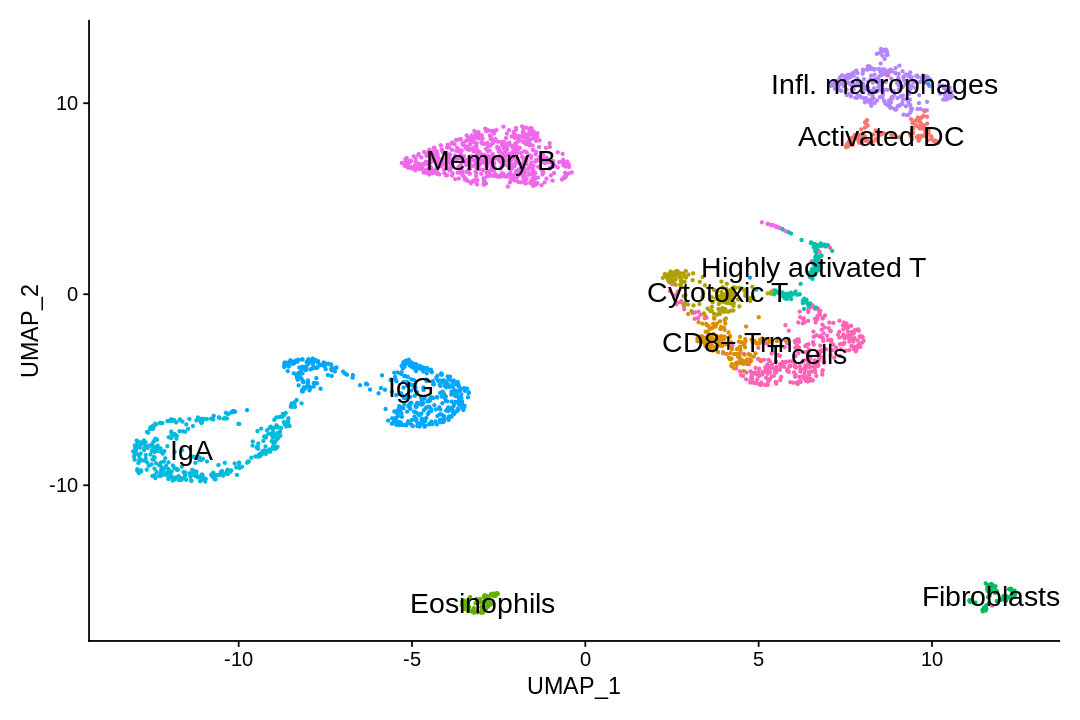

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
UMAPPlot(seu, group.by = "cell_type", label = TRUE, label.size = 6) + NoLegend()

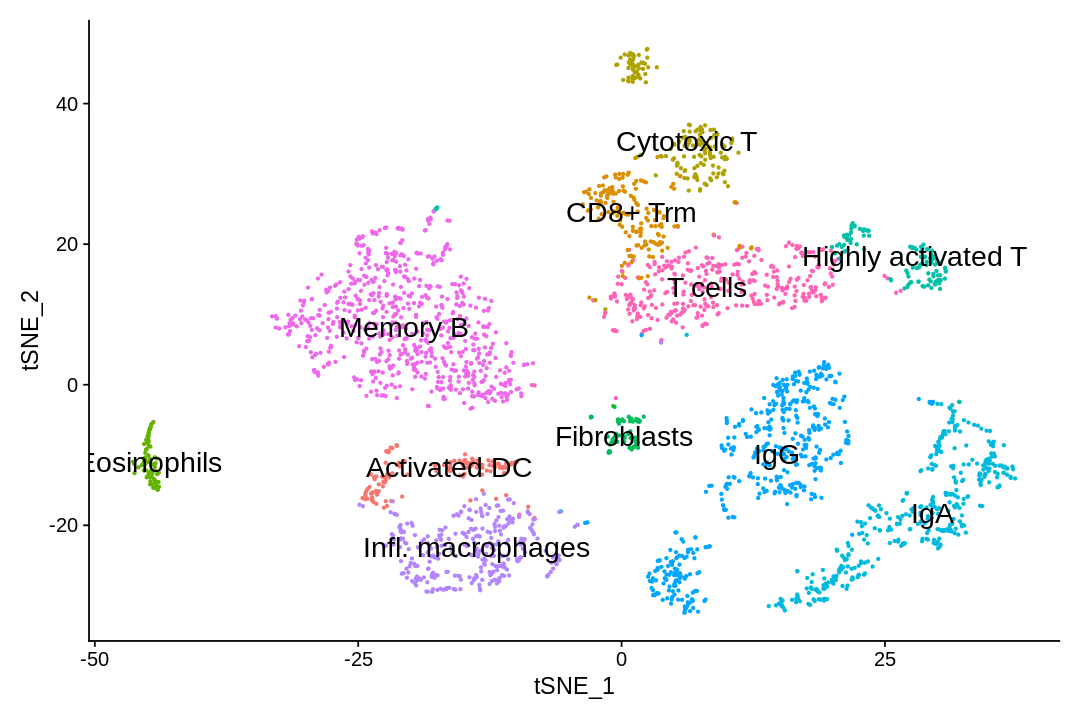

In [0]:
TSNEPlot(seu, group.by = "cell_type", label = TRUE, label.size = 6) + NoLegend()

In [0]:
Sys.time() - start_time

Time difference of 25.63406 mins

The whole notebook, from making the gene count matrix from fastq files to GSEA, took about 26 minutes. Further analyses can be done, such as finding gene coexpression modules and comparison with healthy tissue and samples from other patients to identify gene programs specific to the lesion or specific to a subset of patients. 